*Francisco Javier Sáez Maldonado
José Antonio Álvarez Ocete*

# Motivación

En el campo del aprendizaje automático, es crucial que los algoritmos que buscan el óptimo en un problema de optimización sean lo más rápidos ejecutando posible. Sabemos que, cuando un modelo tiene que entrenar sobre un conjunto de datos de entrenamiento, el tamaño de los datos es una parte clave en este proceso. 

Si tenemos dos conjuntos de datos sobre los que aplicar un algoritmo que tienene el mísmo número de elementos pero en el primer conjunto de datos $\mathcal D_1$, los elementos $x_i$ son vectores de $\mathbb R^2$, mientras que en el segundo conjunto de datos $\mathcal D_2$ los elementos son vectores de $\mathbb R^{100}$, la optimización será mucho más rápida en el conjunto $\mathcal D_1$ por serlo el número de operaciones que tiene que hacer el algoritmo. Este problema crece de forma muy seria cuando consideramos, por ejemplo, problemas de aprendizaje profundo con imágenes en los que cada imagen tiene dimensiones $N \times M$ y tenemos en cuenta que siempre interesa tener el mayor número de ejemplos disponibles para entrenar nuestro modelo.

Es por esto que en situaciones en las que la dimensionalidad del conjunto de datos es alta, cobra gran peso la **creación de representaciones** de nuestros datos originales. Podemos definir el concepto de representación del siguiente modo: Supongamos que tenemos un vector de alta dimensionalidad, $x \in \mathbb R^n$. Una representación de $x$ es otro vector $x' \in \mathbb R^d$ con $d < n$ (o, idealmente, $d << n$) que contiene la misma información que el vector inicial $x$.

Conseguir representaciones que nos hagan no perder información de los datos iniciales a la vez que reducimos la dimensionalidad considerablemente es un proceso bastante complejo. En los últimos años ha cobrado bastante importancia, surgiendo nuevos modelos de redes neuronales convolucionales que aprenden a crear representaciones utilizando el conjunto de entrenamiento ([BYOL](https://arxiv.org/abs/2006.07733), [SimCLR](https://arxiv.org/abs/2002.05709)) sobre todo en el campo de la **visión por computador**, donde la gran dimensionalidad de las imágenes es un cuello de botella para la eficiencia de los procesos de entrenamiento.

Una buena idea para la creación de representaciones es utilizar los conceptos que la *teoría de la información* nos proporciona. El concepto de **entropía** de una variable aleatoria es una medida de la **incertidumbre** que tenemos de que una variable aleatoria ocurra. Se puede expresar como:
$$
H(X) = \mathbb E_X \left[\log \frac{1}{P(x)}\right] = - \mathbb E_X [\log(P(x))].
$$

Usando la entropía, podemos definir el concepto de **información mutua** (aunque podría no ser la más habitual), del siguiente modo:
$$
I(X,Y) = H(X) - H(X|Y).
$$
Gracias a esta definición, podemos dar una explicación bastante intuitiva de lo que es esta información mutua: el *decrecimiento de incertidumbre de que la variable aleatoria* $X$ *ocurra, sabiendo que ha ocurrido la variable aleatoria* $Y$.

Podemos aplicar esto al aprendizaje de representaciones. Si llamamos $X$ a los datos originales, e $Y$ a la representación que creamos de estos datos, la $I(X,Y)$ en este caso nos diría cuánta incertidumbre estamos perdiendo al usar la representación $Y$ del vector $X$ en vez del propio vector $X$. Por tanto, nos gustaría que esta información mutua fuese en este caso lo mayor posible.

En nuestro caso, querremos calcular la información mutua entre las distintas series temporales que nos encontraremos en nuestro conjunto de datos. En los datos habrá *spikes* en las series, y querremos ver qué relacion tienen estas series temporales mediante los spikes de estas series.


Realizaremos un estudio de la entropía, información mutua y transferencia de información entre distintas series temporales del mundo real, utilizando distintas formas de representación para los datos. El índice seguido es el siguiente:

1. Procesamiento de los datos
2. Buscando el tamaño de ventana óptimo
3. Cálculo de la entropía e información mutua
4. Experimentación 
    1. Estudio de  la entropía, información mutua y transferencia de información en nuestras señales.
    2. Repercusión del tamaño de ventana sobre la información mutua y transferencia de información.
5. Cambio de codificación: SAX
    1. Experimentos sobre los hiperparámetros de SAX
    2. Estudio de hiperparámetros: tamaño de alfabeto
    3. Comparativa de representaciones
6. Conclusiones


# 1. Procesamiento de los datos

Lo primero que debemos saber es qué tienen los datos a los que nos vamos a enfrentar. Las series temporales que se nos proporcionan tiene una serie de *spikes*, que indican eventos en nuestro problema. Idealmente, si no queremos perder ninguna información nos gustaría reducir el conjunto de datos inicial sin perder ningún spike.

Detectados los spikes, querremos reducir los datos utilizando *ventanas* de tamaño $n$. Condensaremos la información de cada una de estas ventanas para reducir la dimensionalidad de la señal inicial.

Comenzamos importando las librerías principales que usaremos para la práctica

In [1]:
import pandas as pd
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import pickle

np.random.seed(123)

interval = 0.1
plt.rcParams['figure.figsize'] = [10, 5]

# Functions used to store objects in memory so that we do not have to re-compute them
def save_object(o, name):
    # open a file
    with open(name,'wb') as f:
        # dump object to that file
        pickle.dump(o,f)
    
def load_object(name):
    # open a file, where you stored the pickled data
    with open(name,'rb') as f:
        return pickle.load(f)


Lo primero que debemos hacer es leer los datos de los ficheros proporcionados. Para ello, teniendo los archivos descomprimidos, podemos leerlos a *dataframes* de `python` simplemente usando la función `read_csv` con ciertos parámetros para leerlos de forma que nos interese. En el archivo *InformaciónFicheros.txt* tenemos la información sobre los datos que encontraremos en los tres ficheros. Vemos que tanto el trozo C (Control) y el trozo R (Recuperación) tienen dos columas: LP y VD. El fichero G (GABA) esas dos y una tercera columna donde se muestra el tiempo y duración precisa de inyección de GABA al 4º spike de VD. Los leemos y mostramos 10 del *trozo G*, que será el que **utilicemos para el análisis profundo** de buscar un tamaño de ventana adecuado.

In [2]:
trozoC = pd.read_csv("inputs/TrozoC.txt", names = ["LP", "VD"], 
                     delimiter = "\t", skiprows = range(3), 
                     index_col = False, decimal = ",")

In [3]:
trozoG = pd.read_csv("inputs/TrozoG.txt", names = ["LP", "VD","T"],
                     usecols = [0, 1, 2],
                     delimiter = "\t", skiprows = range(3), 
                     index_col = False, decimal = ",")

In [4]:
trozoR = pd.read_csv("inputs/TrozoR.txt", names = ["LP", "VD"], 
                     delimiter = "\t", skiprows = range(3), 
                     index_col = False, decimal = ",")

In [5]:
trozoG.head(10)

,LP,VD,T
0,-0.006104,0.064697,0.120239
1,-0.004272,0.075989,0.126343
2,-0.003357,0.087280,0.125427
3,-0.005188,0.092468,0.123596
4,-0.007324,0.093384,0.118713
5,-0.010681,0.089722,0.105896
6,-0.004883,0.086975,0.127258
7,0.004272,0.092468,0.111084
8,0.002441,0.087585,0.114136
9,0.003357,0.080872,0.110779


Podemos obtener también información visual sobre los datos con los que vamos a trabajar. Para ello, creamos una función que nos dibujará los datos en un intervalo $[x_1,x_2]$ que le indiquemos. Podemos verlo en el siguiente gráfico:

In [6]:
def plot_data_interval_lines(data = trozoG,lines = [],lines_titles = [], x = [0,10000]):
    
    cols = len(data.columns)
    if len(lines) > 0 and len(lines) != cols:
        raise ValueError("Incorrect number of lines passed")
    
    #df = part.head(first_n).copy()
    #x_values = np.arange(x[0],x[1]+0.1,interval)
    x_values = np.arange(x[0],x[1],1)
    #x_values = [i*interval for i in range(first_n)]
    
    colors = plt.cm.get_cmap('rainbow',cols + len(lines))

    fig, axs = plt.subplots(cols)
    fig.suptitle('Intervalo [{},{}] milisegundos'.format(x[0],x[1]))

    for j in range(cols):
        axs[j].plot(x_values, data.iloc[:, j][x[0]:x[1]], label = data.columns[j],color = colors(j),linewidth = 1)
        if len(lines) > 0:
            y_values = [lines[j] for i in x_values]
            axs[j].plot(x_values,y_values,color = colors(j+cols),label = lines_titles[j], linewidth = 1)
            
        axs[j].legend(loc="upper right")
        

    axs[cols-1].set_xlabel('Tiempo (milisegundos)')
    plt.show()

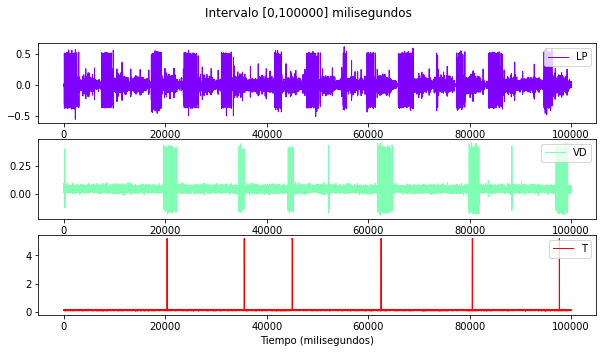

In [7]:
plot_data_interval_lines(trozoG,x = [0,100000])

Podemos observar que las señales son inestables y que hay grandes oscilaciones entre los valores. Nuestro objetivo ahora va a ser discretizar las señales para que sean únicamente secuencias de ceros (si el punto no es parte de un spike) y unos (si el punto sí es parte del spike). Para ello, vamos a establecer un umbral a partir del cual diremos que un punto es un spike. Existen numerosas técnicas para establecer umbrales a partir de los que se dice que un dato es atípico. En nuestro caso, hemos seguido un método de *ensayo-error*. Sabemos que queremos dejar gran parte de los datos fuera y detectar solo aquellos cuya altura sea mayor que el resto, por lo que utilizaremos un percentil. En particular, decidimos utilizar el *percentil $99.7\%$*, pues es el que empíricamente nos hace no dejarnos spikes sin detectar.

In [8]:
def get_quantiles(df,q = [.997,.997,.997]):
    qs = df.quantile(q)
    return np.diag(qs)

Podemos usar la función de dibujado anterior pasándole *líneas*, valores en los que dibujar una función $f(x) = y$ constante. Tras calcular los percentiles para cada una de las columnas de nuestro trozo G, las dibujamos para ver si se ajustan adecuadamente a no perder ningún spike:

Cuantil 99.7:
 [0.492554 0.339661 5.144653]


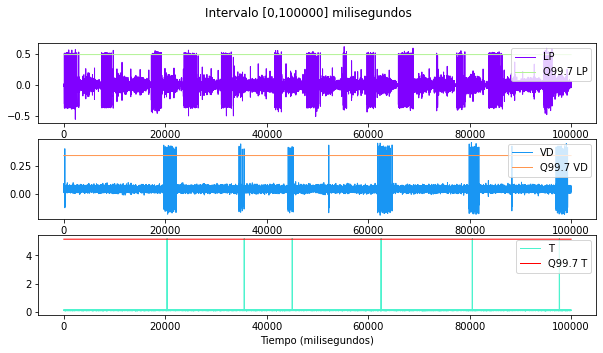

In [9]:
q997 = get_quantiles(trozoG)
print("Cuantil 99.7:\n {}".format(q997))
plot_data_interval_lines(trozoG,lines = q997,lines_titles = ["Q99.7 LP", "Q99.7 VD", "Q99.7 T"],x = [0,100000])

Esta última gráfica (la de $T$) no nos interesará, pues no utilizaremos el tiempo para nuestro análisis. Además, vamos a hacer lo siguiente: puesto que los valores que realmente tome la serie temporal no son lo más importante, sino que lo importante es el hecho en sí de que haya un spike, vamos a convertir la serie temporal a una secuencia de $0$ y $1$, aplicando tanto a $LP$ como a $VD$ la siguiente función:
$$
f_{h}(x) = \begin{cases}
1 & \text{ si } x > h\\
0 & \text{ si } x \leq h
\end{cases}
$$
donde $h$ será el umbral o threshold que establezcamos a partir del cual consideramos que los datos están teniendo un spike.

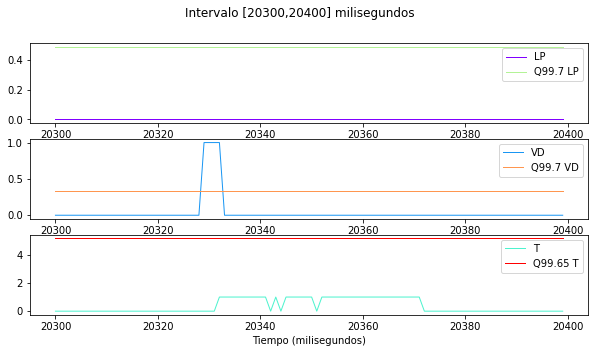

In [10]:
trozoG_thresh = (trozoG > q997).astype(int)
plot_data_interval_lines(trozoG_thresh,lines = q997, lines_titles = ["Q99.7 LP", "Q99.7 VD", "Q99.65 T"],  x =[20300,20400]) 



# 2. Buscando el tamaño de ventana óptimo


Como su nombre sugiere, en esta sección buscaremos el mejor tamaño de ventana posible. Esto es, el mayor tamaño de ventana posible (para crear una representación de tamaño lo más reducido posible de nuestras series temporales) que no afecte a la calidad de los resultados: debemos de perder el menor número de spikes posibles.

Vamos a realizar el análisis con el trozo G y luego continuaremos con el resto.


## Trozo G

Hasta ahora, nuestra señal se ha convertido en un vector de ceros y unos. Los spikes en la señal tienen una subida y una bajada que estará por encima del umbral, pero dentro de la subida y bajada, estamos en el mismo spike. Es por ello que podemos considerar una consecución de $1$ seguidos como un único spike, y considerar únicamente el punto medio de este spike para contabilizarlo como spike.

En las siguientes dos celdas continuamos con el preprocesado:

- Creamos una función `select_middle_point` que, dada una serie de ceros y unos representando los spikes, reduce cada spike (cada cadena de unos seguidos) a su punto medio. De esta forma, evaluar si hay un spike en una ventana es verificar si hay un uno en la misma.
- Creamos una segunda función `get_spikes_separation` que obtiene información sobre la distancia entre spikes: la distancia media, las mínima y máxima, todas las distancias entre spikes... Y la ejecutamos para las distintas series temporales (LP, VD y GABA) tras haberle aplicado la función `select_middle_point`.

In [11]:
def select_middle_point(df):
    for col in range(len(df.columns)):
        vec = np.array(df.iloc[:,col])
        i = 0
        while i < len(vec):
            j = 0
            found_one = False
            # Count length of followed 1s
            while(vec[i+j] == 1):
                j +=1
                found_one = True
            
            if found_one:
                # Keep only the one in the middle
                vec[i:i+j] = 0
                vec[i+int(j/2)] = 1
                # Update position
                i += j
            i += 1
        #Update vector in df
        df.iloc[:,col] = vec

    return df
trozoG_single_peak = select_middle_point(trozoG_thresh)

In [12]:
import re
from tqdm import tqdm
import itertools
from operator import itemgetter
def get_spikes_separation(df):
    dicts = [ {} for i in range(len(df.columns)) ]
    #vs = []
    for j in range(len(df.columns)):
        dtype = [('spike',int),('length',int)]
        v = np.array([ (x , len(list(y)))
                     for x, y in itertools.groupby(df.iloc[:,j])],
                     dtype=dtype)
        a = np.sort(v,order=['spike','length'])
        ones = np.array([v[1] for v in a if v[0] == 1])
        zeros = np.array([v[1] for v in a if v[0] == 0])
        dicts[j]['max_stop'] = np.amax(zeros)
        dicts[j]['min_stop'] = np.amin(zeros)
        dicts[j]['avg_stop'] = np.mean(zeros)
        dicts[j]['num_stops'] = len(zeros)
        dicts[j]['num_spikes'] = len(ones)
        dicts[j]['zeros'] = zeros

    return dicts
    
info = get_spikes_separation(trozoG_single_peak)

In [13]:
info

[{'max_stop': 14349,
  'min_stop': 43,
  'avg_stop': 682.179092652823,
  'num_stops': 23982,
  'num_spikes': 23981,
  'zeros': array([   43,    83,    84, ..., 12719, 12822, 14349])},
 {'max_stop': 21409,
  'min_stop': 70,
  'avg_stop': 1105.35431156729,
  'num_stops': 14809,
  'num_spikes': 14808,
  'zeros': array([   70,    71,    72, ..., 20803, 21352, 21409])},
 {'max_stop': 76335,
  'min_stop': 1,
  'avg_stop': 3811.892948568769,
  'num_stops': 4297,
  'num_spikes': 4296,
  'zeros': array([    1,     1,     1, ..., 44641, 72094, 76335])}]

Dibujamos un histograma de la separación que tenemos entre spikes:

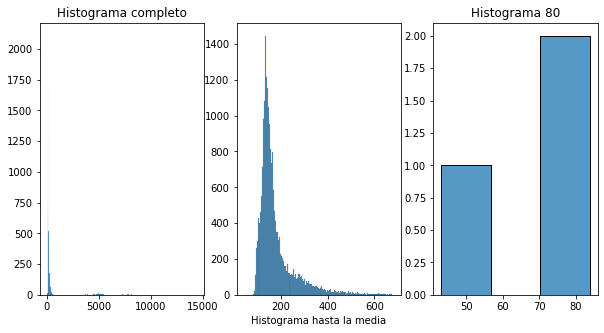

In [14]:
import seaborn as sns
#_ = plt.hist(info[0]['zeros'])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
a = info[0]['zeros'].copy()

a_cut = a[ a < info[0]['avg_stop']]
a_cut2 = a[a < 85]

_ = sns.histplot(a,ax=ax1)
_ = sns.histplot(a_cut,ax=ax2)
_ = sns.histplot(a_cut2,ax=ax3)

for ax in [ax1,ax2,ax3]:
    ax.set_ylabel("")

ax1.set_title( "Histograma completo")
ax2.set_xlabel( "Histograma hasta la media") 
ax3.set_title("Histograma 80")

plt.show()

Al dibujar el histograma de las diferentes separaciones entre spikes en $LP$, nos damos cuenta de que aunque la mayoría de separaciones entre los mismos son pequeñas, existen valores que podrían salirse de la normalidad (outliers). En la información recabada sobre los spikes y los *tiempos sin spike*, obtenemos que la mínima distancia entre spikes para este trozo es de $43$ microsegundos. Sin embargo, realizando los tres histogramas anteriores hemos visto que es un único valor el que tiene esta pequeña distancia entre spike, por lo que podemos considerarlo un dato anómalo. Es por ello que decidimos eliminarlo para poder aumentar así el tamaño de ventana. 

A continuación, hacemos la misma comprobación para el caso de $VD$ nos damos cuenta de que no ocurre lo mismo, y que sí tenemos bastantes espacios entre spikes moviéndose en el intervalo $[70,80]$ por lo que no consideramos ningún outlier inferior en este caso.

Los outliers superiores no los consideramos pues no afectan a nuestra decisión para el tamaño de ventana.

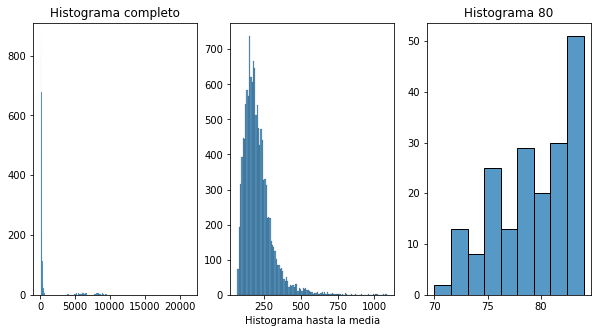

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
a = info[1]['zeros'].copy()

a_cut = a[ a < info[1]['avg_stop']]
a_cut2 = a[a < 85]

_ = sns.histplot(a,ax=ax1)
_ = sns.histplot(a_cut,ax=ax2)
_ = sns.histplot(a_cut2,ax=ax3)

for ax in [ax1,ax2,ax3]:
    ax.set_ylabel("")

ax1.set_title( "Histograma completo")
ax2.set_xlabel( "Histograma hasta la media") 
ax3.set_title("Histograma 80")

plt.show()

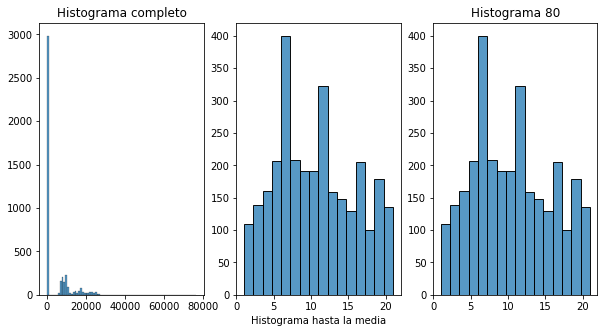

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
a = info[2]['zeros'].copy()

a_cut = a[ a < info[1]['avg_stop']]
a_cut2 = a[a < 85]

_ = sns.histplot(a,ax=ax1)
_ = sns.histplot(a_cut,ax=ax2)
_ = sns.histplot(a_cut2,ax=ax3)

for ax in [ax1,ax2,ax3]:
    ax.set_ylabel("")

ax1.set_title( "Histograma completo")
ax2.set_xlabel( "Histograma hasta la media") 
ax3.set_title("Histograma 80")

plt.show()

Escribimos por tanto una función que elimine los outliers, considerando como outliers los spikes que tengan menos separación que $70$ con otro spike. Si volvemos a mostrar la información, obtenemos que se han eliminado estos tras aplicar la función.

In [17]:
def remove_outliers(df_safe, threshold_outlier = 70):
    df = df_safe.copy()
    for j in range(len(df.columns)):
        dtype = [('spike',int),('length',int)]
        v = np.array([ (x , len(list(y)))
                     for x, y in itertools.groupby(df.iloc[:,j])],
                     dtype=dtype)
        
        idx = [i for i,tupl in enumerate(v) if tupl[0] == 0 and tupl[1] < threshold_outlier ]
        for i in idx:
            # Keep between the bounds
            if i != len(v)-1:
                v[i+1][0] = 0
            else:
                v[i-1][0] = 0

        df.iloc[:,j] = np.concatenate([np.repeat(x[0],x[1]) for x in v ])


    return df

In [18]:
trozoG_no_outliers = remove_outliers(trozoG_single_peak)
info_no_outliers = get_spikes_separation(trozoG_no_outliers)
info_df = info_no_outliers.copy()
for d in info_df:
    del d['zeros']
show = pd.DataFrame(info_df)
print(show)

   max_stop  min_stop      avg_stop  num_stops  num_spikes
0     14349        83    682.207581      23981       23980
1     21409        70   1105.354312      14809       14808
2     76364      6145  12467.798326       1314        1313


Eliminados los outliers, tenemos nuestro vector de ceros y unos preparado para dividirlo en ventanas. 

**¿Cuál es el tamaño máximo de ventana que podemos tomar de forma que una ventana no capture dos spikes? Es sencillo: el mínimo de las distancias entre spikes.**

In [19]:
def reduce_using_windows(df, window_size):

    index = np.arange(0, len(df.iloc[:,0]) + 1, window_size)
    result = pd.DataFrame(columns=df.columns)
    for i,col in enumerate(df.columns):
        result.iloc[:,i] = np.array([1 if 1 in np.array(df[col][i1:i2])
                                    else 0 
                                    for i1,i2 in zip(index[:-1],index[1:])]) 

    return result

reduced =  reduce_using_windows(trozoG_no_outliers, 70)

In [20]:
def print_v(text,verbose):
    if verbose:
        print(text)
        
def discretize_data(df, verbose = False):
    
    print_v("Computing quantile and applying threshold...", verbose)
    # Compute Quantile 99.7
    #q997 = df.quantile(.997)
    qs = get_quantiles(df,q=[.997,.997,.997])

    # Apply threshold using Quantile 99.7
    df_thresh = (df > qs).astype(int)#.drop(labels = ['T'],axis=1)

    print_v("Selecting middle points...", verbose)
    # Erase spike repetitions using the middle point
    df_middle_points = select_middle_point(df_thresh)

    print_v("Removing outliers...", verbose)
    # Remove outliers
    df_no_outliers = remove_outliers(df_middle_points)
    
    return df_no_outliers

    
def create_representation(df, w_size, verbose=False):
      # Compute optimal window size to avoid collisions
    if w_size == None:
        print_v("Obtaining information about spike separation...", verbose)
        # Obtain distance between spikes.
        info = get_spikes_separation(df)

        # Select window size
        w_size = min([info[i]['min_stop'] for i in range(len(df.columns))]) 
    
    print_v("Reducing data using windows. Window size: {}...".format(w_size), verbose)
    # Reduce using window size
    discretized_data = reduce_using_windows(df,w_size)

    return discretized_data
    
def representation(df,w_size = None, verbose = False):
    
    discretized = discretize_data(df, verbose)
    
    return create_representation(discretized,w_size,verbose)

In [21]:
representation_G = representation(trozoG,verbose=True)
#representation_G = load_object("representation_G")

Computing quantile and applying threshold...
Selecting middle points...
Removing outliers...
Obtaining information about spike separation...
Reducing data using windows. Window size: 70...


Hemos creado una función `representation` que, dado una de las partes de todos nuestros datos, lo discretiza, elimina los outliers, halla información sobre el mismo para poder calcular el tamaño de ventana más grande posible y luego reduce nuestro conjunto usando esa ventana. Veamos qué cantidad de información (en espacio) hemos mantenido respecto al tamaño original:

In [22]:
print("Nos hemos quedado con el {} del tamaño inicial".format(len(representation_G.iloc[:,0])/len(trozoG.iloc[:,0])*100))

Nos hemos quedado con el 1.4285705566406248 del tamaño inicial


Podemos observar que la salida nos indica que tenemos el $1.42\%$ del tamaño inicial, lo cual indica que hemos reducido nuestros datos de forma muy considerable sin perder ningun spike por el camino.

## Trozo C

Teniendo las funciones realizadas, podemos mostras primero la información y luego realizar también la representación para el trozo C.


In [23]:
qs = get_quantiles(trozoC)
trozoC_thresh = (trozoC > qs).astype(int)
trozoC_middle_points = select_middle_point(trozoC_thresh)
# Distinguish between outliers and no outliers
trozoC_no_outliers = remove_outliers(trozoC_middle_points)
# Information
info_no_outliers = get_spikes_separation(trozoC_no_outliers)
info_outliers = get_spikes_separation(trozoC_middle_points)
info_df = info_outliers.copy()
info_no_outliers = info_no_outliers.copy()
for d in info_df:
    del d['zeros']
for d in info_no_outliers:
    del d['zeros']
show = pd.DataFrame(info_df)
print("Info trozo C with outliers")
print(show)
show = pd.DataFrame(info_no_outliers)
print("Info trozo C with NO outliers")
print(show)

Info trozo C with outliers
   max_stop  min_stop     avg_stop  num_stops  num_spikes
0     28863        85   697.518371      28414       28413
1     31593        16  1024.138216      19361       19360
Info trozo C with NO outliers
   max_stop  min_stop     avg_stop  num_stops  num_spikes
0     28863        85   697.518371      28414       28413
1     31593        71  1024.614975      19352       19351


Podemos ver como al eliminar los outliers (que, si recordamos el código inicial, lo hacíamos para esas paradas que estuviesen por debajo de una duración de $70$), apenas estamos modificando el tamaño de nuestro conjunto mientras que estamos eliminando lo que probablemente nos haría obtener una estimación peor de la información mutua entre las señales. Es por ello que decidimos crear la representación de este nuevo trozo utilizando exactamente el mismo procedimiento que en el anterior. 

In [24]:
representation_C = representation(trozoC,verbose=True)
#representation_C = load_object("representation_C")

Computing quantile and applying threshold...
Selecting middle points...
Removing outliers...
Obtaining information about spike separation...
Reducing data using windows. Window size: 71...


# Trozo R

Hacemos exactamente el mismo análisis para este último trozo.


In [25]:

qs = get_quantiles(trozoR)
trozoR_thresh = (trozoR > qs).astype(int)
trozoR_middle_points = select_middle_point(trozoR_thresh)
# Distinguish between outliers and no outliers
trozoR_no_outliers = remove_outliers(trozoR_middle_points)
# Information
info_no_outliers = get_spikes_separation(trozoR_no_outliers)
info_outliers = get_spikes_separation(trozoR_middle_points)
for d in info_no_outliers:
    del d['zeros']
for d in info_outliers:
    del d['zeros']
show = pd.DataFrame(info_outliers)
print("Info trozo R with outliers")
print(show)
show = pd.DataFrame(info_no_outliers)
print("Info trozo R with NO outliers")
print(show)

Info trozo R with outliers
   max_stop  min_stop     avg_stop  num_stops  num_spikes
0     29155        25   906.097830      18062       18061
1     31593        16  1029.894167      15893       15892
Info trozo R with NO outliers
   max_stop  min_stop     avg_stop  num_stops  num_spikes
0     29155        85   906.248519      18059       18058
1     31593        71  1030.543222      15883       15882


In [26]:
representation_R = representation(trozoR,verbose=True)
#representation_R = load_object("representation_R")

Computing quantile and applying threshold...
Selecting middle points...
Removing outliers...
Obtaining information about spike separation...
Reducing data using windows. Window size: 71...


# 3. Entropía. Información Mutua. Transferencia de Información.

Obtenidas las representaciones que mantienen toda la información acerca de los spikes, queremos ver qué cantidad de información mutua obtenemos. PAra ello, lo primero que debemos considerar es que debemos dividir los datos en palabras, que nos crearán los eventos del conjunto de datos. Estas palabras se solaparán. De forma visual, si nuestro conjunto de datos es 
$$
X = \begin{pmatrix} 1 & 0 & 0 & 1 & 0 \\ 
1 & 0 & 0 & 1 & 0 \end{pmatrix},
$$
si usamos una palabra de tamaño $2$, los eventos que tendríamos serían:
$$
X' = \begin{pmatrix} \begin{pmatrix}1 & 0 \\ 1 & 0 \end{pmatrix},\begin{pmatrix}0 & 0 \\ 0 & 0 \end{pmatrix}, \begin{pmatrix}0 & 1 \\ 0 & 1 \end{pmatrix}, \dots \end{pmatrix}.
$$

Se nos propone que consideremos como tamaños de palabra subconjuntos de $1$ a $8$ bits. Teniendo nuestros datos divididos en palabras y considerando como hemos dicho cada palabra como un evento, podemos calcular empíricamente las probabilidades de cada uno de los eventos, contando el número de ocurrencias de cada evento y dividiéndolas por el número de eventos totales.

Aunque En la motivación comentamos que la información mutua se expresa como $I(X,Y) = H(X) - H(X|Y)$, existe una forma más conveniente para nosotros de calcularla:
$$
I(X,Y) = H(X) + H(Y) - H(X,Y),
$$
donde $H(X,Y)$ es la entropía conjunta de ambas variables aleatorias.

Además, calcularemos la transferencia de información que tenemos entre las dos series temporales, tanto de LP a VD como de VD a LP. Sabemos que si $X,Y$ son dos variables aleatorias, la transferencia de información viene dada por
$$
E_{XY} = \frac{I(X,Y)}{H(Y)}.
$$

Por último, queremos ver cómo afecta el tomar ventanas más grandes para la información mutua respecto a los otros tamaños de palabra y si esto es relevante en la información mutua obtenida. Es por ello que añadimos una función que nos calcula la información mutua normalizada dado un tamaño de ventana. Esta viene dada por la expresión:
$$
\hat I(X,Y) = \frac{I(X,Y)}{window\_size *n\_bits}
$$

Puesto que vamos a calcular la información mutua a partir de entropías, consideramos que lo mejor es intentar almacenar de algún modo las entropías de las variables y la entropía conjunta, por lo que encapsulamos este comportamiento en una clase de `Python`. 

In [27]:
class MI:
    """
    Mutual Information computation using the Entropy of two random variables.

    """

    def __init__(self, X, Y, word_sizes):
        """
        Initialization of the class. The init method computes all the values but the Normalized MI, since it needs a window size
        Args:
            - X : np array Random variable X
            - Y : np array Random variable Y
            - word_sizes : np array with a range of word sizes
        """
        self.X = X
        self.Y = Y
        self.word_sizes_ = word_sizes
        self.entropies_computed_ = False
        self.mi_computed_ = False
        
        # Compute properties
        self.entropies()
        self.mutual_information()
        self.information_transfer()

    def entropies(self):
        """
        Computes the entropy of the random variables stored in the class object
        """
        self.X_entropy = self.__compute_entropy(self.X)
        self.Y_entropy = self.__compute_entropy(self.Y)
        self.XY_entropy = self.__compute_entropy(np.vstack((self.X,self.Y)))
        self.entropies_computed_ = True

    def mutual_information(self):
        """
        Computes the mutual information of the random variables stored in the class object
        """
        if not self.entropies_computed_:
            raise ValueError("Entropies not computed yet.")
        self.mutual_information_ = self.X_entropy + self.Y_entropy - self.XY_entropy
        self.mi_computed_ = True

    def information_transfer(self):
        """
        Computes both the information transfers of the random variables stored in the class object
        """
        if not self.mi_computed_:
            raise ValueError("Mutual Information not computed yet.")
        self.it_XY_ = self.mutual_information_ / self.Y_entropy
        self.it_YX_ = self.mutual_information_ / self.X_entropy

    def __compute_entropy(self,X):
        """
        General computation of the entropy of an MxN signal for each of the prefixed word sizes.
        Args
            - X: np array NxM dimensional that contains the r.v. to compute the entropy
        """
        Hs = np.zeros(len(word_sizes))

        for j,s in enumerate(word_sizes):

            # Divide in words, erase the end
            X_windowed = np.array([ X[:, i:i+s] for i in range(X.shape[1] - s)])

            # Get the unique elements and their frequency
            elems, count = np.unique(X_windowed,axis = 0, return_counts=True)

            # Compute empirical probabilities
            probabilities = count/np.sum((count))

            # Compute entropy
            entropy = - np.sum( probabilities * np.log2(probabilities))

            # Append to vector of entropies
            Hs[j] = entropy

        return Hs
    
    def normalized_mi(self,window_size):
        """
        Computes the normalized mutual informationentropy of the random variables stored in the class object
        Args
            - window_size: the window size used in the representation
        """
        return self.mutual_information_ /(window_size * self.word_sizes_)


    def info_to_dataframe(self):
        """
        Exports all the information stored in the class to a dataframe with visualization purposes
        """
        data = list(zip(self.X_entropy,self.Y_entropy,self.XY_entropy,self.mutual_information_,self.it_XY_,self.it_YX_))
        names = ["H(X)", "H(Y)", "H(X,Y)", "MI(X,Y)", "EX-Y", "EY->X"]
        df = pd.DataFrame(data,index = self.word_sizes_ ,columns = names)
        df.index.name = "W.Length"
        return df

In [28]:
import pickle
    
# Obtain in two random variables two columns from the dataset, reshaped
def get_LP_VD(df):
    data = df.to_numpy()
    X = data[:,0].T.reshape(1,-1)
    Y = data[:,1].T.reshape(1,-1)
    
    return X,Y

def plot_entropies_mi_transfer(estimator, name = "Information about this part"):
    fig, axs = plt.subplots(2, 2, figsize = (11, 10))
    fig.suptitle(name)

    colors = plt.cm.get_cmap(None,6)

    # Plot entropies
    axs[0, 0].set_title("Entropy")
    axs[0, 0].set_xlabel("Word size")
    axs[0, 0].plot(estimator.word_sizes_, estimator.X_entropy, label = "H(LP)")
    axs[0, 0].plot(estimator.word_sizes_, estimator.Y_entropy, label = "H(VD)")
    axs[0, 0].plot(estimator.word_sizes_, estimator.XY_entropy, label = "H(LP, VD)")
    axs[0, 0].legend()

    # Plot MI
    axs[0, 1].set_title("Mutual Information")
    axs[0, 1].set_xlabel("Word size")
    axs[0, 1].plot(estimator.word_sizes_, estimator.mutual_information_, label = "I(LP,VD)",color = colors(1))
    axs[0, 1].legend()

    # Plot MI
    axs[1, 0].set_title("Transfer LP --> VD")
    axs[1, 0].set_xlabel("Word size")
    axs[1, 0].plot(estimator.word_sizes_, estimator.it_XY_, label = "IT(LP,VD)",color = colors(2))
    axs[1, 0].legend()

    # Plot MI
    axs[1, 1].set_title("Transfer VD --> LP")
    axs[1, 1].set_xlabel("Word size")
    axs[1, 1].plot(estimator.word_sizes_, estimator.it_YX_, label = "IT(VD,LP)",color = colors(3))
    axs[1, 1].legend()

    plt.show()

Tras todo este código que hemos hecho para calcular y representar las cantidades mencionadas anteriormente, procedemos a calcularlas comenzando al igual que en la búsqueda del tamaño de ventana: usando el trozo G. Lo calculamos usando la representación de G que hemos considerado óptima, es decir, aquella que utiliza un tamaño de ventana $70$.

In [29]:
# Define the word sizes that we will use
word_sizes = np.arange(1,9,1)
# Obtain LP VD in X,Y
X,Y = get_LP_VD(representation_G)
# Get estimator for G
estimator_G = MI(X,Y,word_sizes)

Tras haber calculado el estimador de la información mutua y el resto de valores, podemos dibujarlos en una tabla y a continuación dibujar gráficas que representan estos valores en función del tamaño de palabra utilizado:

              H(X)      H(Y)    H(X,Y)   MI(X,Y)      EX-Y     EY->X
W.Length                                                            
1         0.476727  0.340279  0.808845  0.008161  0.023982  0.017118
2         0.952589  0.680453  1.600116  0.032927  0.048389  0.034565
3         1.327669  0.989787  2.261479  0.055977  0.056555  0.042162
4         1.653888  1.245157  2.827741  0.071303  0.057265  0.043113
5         1.958193  1.465349  3.340662  0.082880  0.056560  0.042325
6         2.248836  1.668334  3.823815  0.093354  0.055957  0.041512
7         2.529911  1.863648  4.289407  0.104152  0.055886  0.041168
8         2.803843  2.055780  4.743644  0.115979  0.056416  0.041364


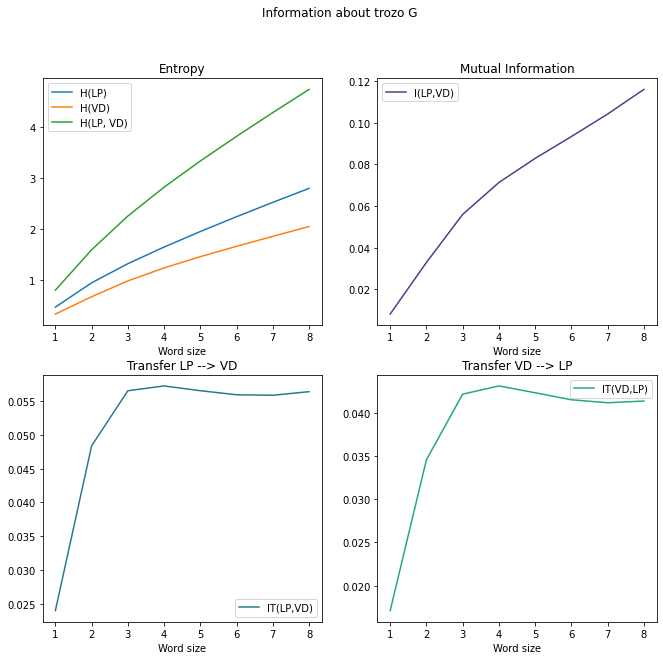

In [30]:
# Print estimator G info and charts
print(estimator_G.info_to_dataframe())

plot_entropies_mi_transfer(estimator_G, name = "Information about trozo G")

Vemos en las gráficas dibujadas para este trozo que tanto la información mutua entre las dos variables como la entropía de las variables crece con el tamaño de palabra utilizado. Alcanza un valor final de aproximadamente $0.12$. Podemos ver que la transferencia de información entre ambas series tiene un gráfico similar, aunque los valores que alcanza no son los mismos, siendo mayor la transferencia $LP \to VD$ que la $VD \to LP$.

Vamos a repetir el proceso en el **trozo C**.

In [31]:
# Get LP and VD for trozo C
X,Y = get_LP_VD(representation_C)
# Compute MI estimator for trozo C
estimator_C = MI(X,Y,word_sizes)

              H(X)      H(Y)    H(X,Y)   MI(X,Y)      EX-Y     EY->X
W.Length                                                            
1         0.474174  0.363019  0.827693  0.009501  0.026172  0.020037
2         0.947925  0.726036  1.634533  0.039428  0.054306  0.041594
3         1.308097  1.026805  2.272175  0.062727  0.061090  0.047953
4         1.622740  1.269995  2.814939  0.077795  0.061256  0.047941
5         1.915477  1.490646  3.316385  0.089738  0.060201  0.046849
6         2.194324  1.699802  3.793536  0.100591  0.059178  0.045841
7         2.463296  1.904616  4.256369  0.111544  0.058565  0.045282
8         2.724564  2.106769  4.708347  0.122985  0.058376  0.045140


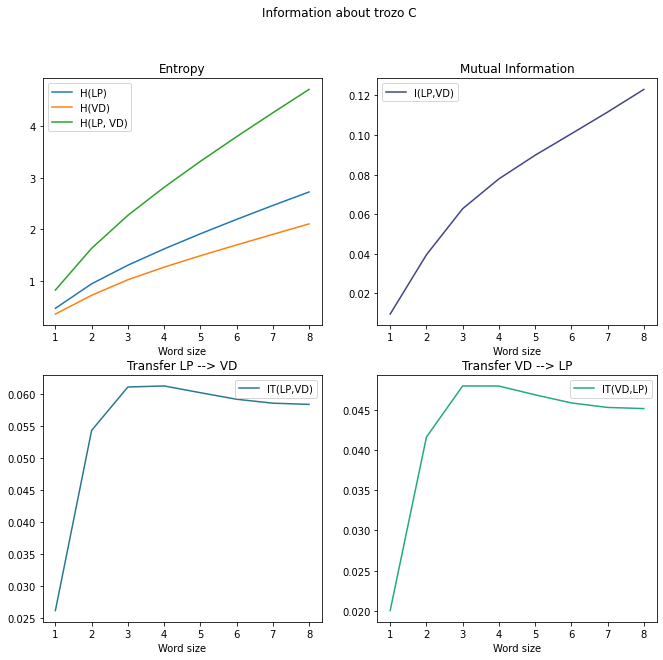

In [32]:
# Print estimator C Values
print(estimator_C.info_to_dataframe())

# Plot information
plot_entropies_mi_transfer(estimator_C, name = "Information about trozo C")

Tras observar las gráficas, vemos que el comportamiento es prácticamente idéntico. Tanto la información mutua como la entropía son monótonas crecientes según el tamaño de palabra. De nuevo, las transferencias de información tienen la misma forma, aunque vuelve a ser la transferencia $LP\to VD$ mayor que la contraria. La diferencia con el caso anterior es que en este trozo los valores de transferencia de información que se alcanzan son levemente más altos.

Nos quedaría por analizar el trozo de recuperación (R). Ejecutamos este análisis para este trozo:

In [33]:
# Get LP and VD for trozo R
X,Y = get_LP_VD(representation_R)
# Compute MI estimator for trozo R
estimator_R = MI(X,Y,word_sizes)

              H(X)      H(Y)    H(X,Y)   MI(X,Y)      EX-Y     EY->X
W.Length                                                            
1         0.396000  0.361524  0.750408  0.007115  0.019681  0.017968
2         0.791525  0.722972  1.485381  0.029116  0.040273  0.036785
3         1.124089  1.023804  2.099237  0.048656  0.047525  0.043285
4         1.432329  1.271019  2.639778  0.063571  0.050016  0.044383
5         1.723346  1.494395  3.141705  0.076036  0.050881  0.044121
6         2.001955  1.706574  3.621117  0.087412  0.051221  0.043663
7         2.272668  1.913693  4.087722  0.098638  0.051543  0.043402
8         2.538174  2.117906  4.546013  0.110067  0.051970  0.043365


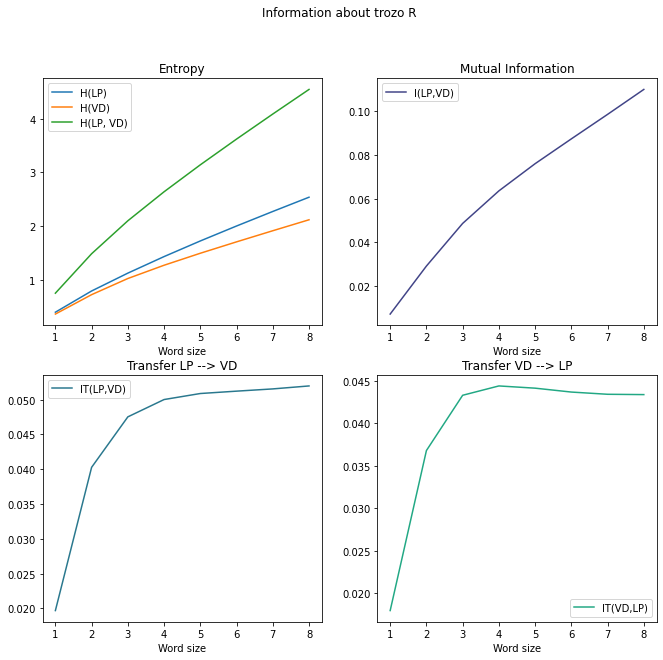

In [34]:
# Print estimator R Values
print(estimator_R.info_to_dataframe())

# Plot information for trozo R
plot_entropies_mi_transfer(estimator_R, name = "Information about trozo R")

En este caso, podemos observar algunas diferencias más respecto a los casos anteriores. En el caso de la entropía no hay variación. Sin embargo, vemos como la información mutua desciende levemente  alrededor de $0.01$ respecto al caso anterior y  algo menos respecto al primer caso, siendo la más baja de las tres. Esto podría tener sentido en el ámbito global de nuestro problema donde sabemos que en el trozo G se ha inyectado GABA al sujeto de pruebas para ver su reacción y sabemos que éste no ha salido airoso del proceso.

Si nos fijamos además en la transferencia de información, vemos que también ha sufrido una bajada en este caso bastante más considerable, y que además ambas curvas (pero sobre todo la transferencia $LP\to VD$) sigue curvas bastante más suavizadas que en los anteriores casos.

## 4.2 Repercusión del tamaño de ventana sobre la información mutua y transferencia de información

Hasta ahora, todos los experimentos que hemos realizado han sido buscando el tamaño de ventana que no nos hace perder ningún spike. A pesar de que hemos tratado de buscar el tamaño de ventana óptimo para no perder información, queremos comprobar cómo afectaría tomar tamaños de ventana mucho más grandes en los que haya solapamiento  de spikes en una única ventana. Es por ello que vamos a olvidarnos de este tamaño de ventana óptimo y vamos a reducir nuestro conjunto utilizando ventanas mucho más grandes. 

Es necesario comentar que el modo de evaluar si una ventana tiene o no un spike ahora cambia, y decidimos que la representación creada tendrá un $1$ en la posición $i-$ésima si en la ventana $i-$ésima que hemos tomado, hay **al menos un spike**, es decir, uno o más spikes.

In [35]:
from os.path import exists
def window_size_experiment(df,window_sizes,word_sizes,save = True, name_save_object = ""):
    if exists(name_save_object):
        print("Estimators already computed!")
        return load_object(name_save_object)
    # The discretized data is common since it does not use window size, just discretizes peaks
    discretized_df = discretize_data(df,False)
    estimators = []
    for w_size in tqdm(window_sizes):
        # Create representation using w_size
        step = create_representation(discretized_df,w_size = w_size)
        X,Y = get_LP_VD(step)
        estimators.append(MI(X,Y,word_sizes))
    
    if name_save_object != "" and save:
        save_object(estimators,name_save_object)
    return estimators
    

def plot_mi_transfer_estimators(estimators, window_sizes, word_sizes ,name = "Comparison of estimators in this part"):
    fig, axs = plt.subplots(len(word_sizes), 3, figsize = (14, 24))
    fig.suptitle(name)

    colors = plt.cm.get_cmap(None,3)
    
    
    axs[0, 0].set_title("Mutual Information")
    axs[len(word_sizes)-1, 0].set_xlabel("Window size")
        
    axs[0, 1].set_title("Information transfer")
    axs[len(word_sizes)-1, 1].set_xlabel("Window size")
        
        
    axs[0, 2].set_title("Normalized MI")
    axs[len(word_sizes)-1, 2].set_xlabel("Window size")



    for i in range(len(word_sizes)):
        # Plot MI
        axs[i, 0].plot(window_sizes, [est.mutual_information_[i] for est in estimators],color ='green')
        axs[i,0].set_ylabel("Word_size " + str(i+1))
        #axs[i, 0].legend()
    
        
        
        # Plot IT
        axs[i, 1].plot(window_sizes, [est.it_XY_[i] for est in estimators],color=colors(1),label="LP->VD")
        axs[i, 1].plot(window_sizes, [est.it_YX_[i] for est in estimators],color='red',label="VD->LP")
        axs[i, 1].legend()
        
        
        axs[i,2].plot(window_sizes,[est.normalized_mi(window_sizes[j])[i] for j,est in enumerate(estimators)],color='orange')

        # Plot MI
        #axs[i, 2].legend()

    plt.show()

Escogemos tamaños de ventana desde $20$ hasta $2010$ saltando de $50$ en $50$, con el objetivo de que uno de los estimadores sea el que tiene tamaño de ventana $70$ que es el que habíamos calculado como óptimo.

In [36]:
 
w_sizes = np.arange(20,1011,50) 
word_sizes = np.arange(1,9,1)

estimators_G = window_size_experiment(trozoG,w_sizes,word_sizes,save=True, name_save_object = "estimators_G")
estimators_C = window_size_experiment(trozoC,w_sizes,word_sizes,save=True, name_save_object = "estimators_C")
estimators_R = window_size_experiment(trozoR,w_sizes,word_sizes,save=True, name_save_object = "estimators_R")




100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:03<00:00, 12.16s/it]


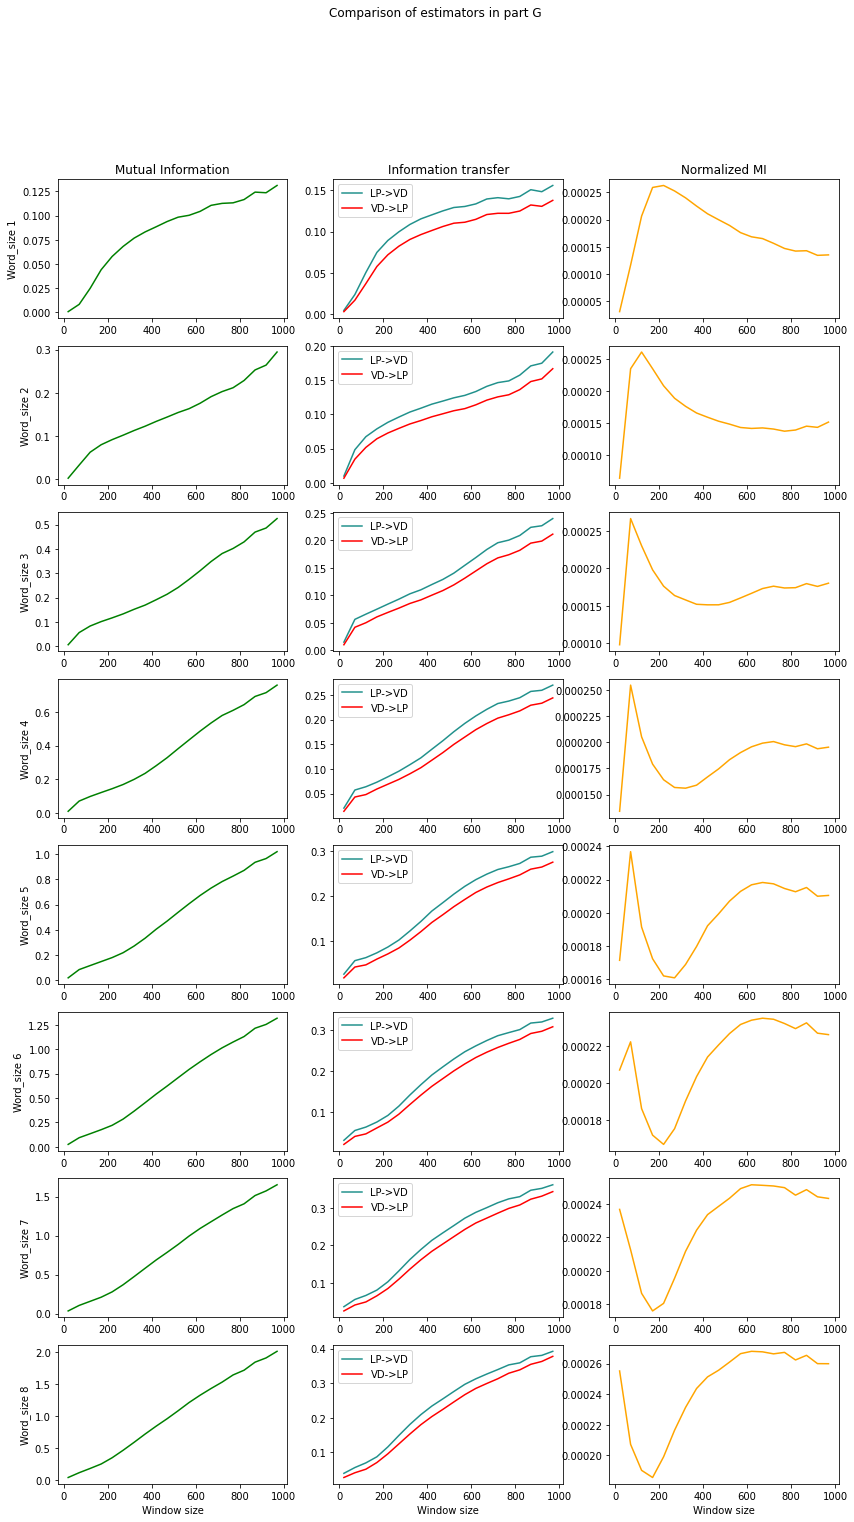

In [37]:
plot_mi_transfer_estimators(estimators_G,w_sizes,word_sizes,name = "Comparison of estimators in part G")

Podemos observar que , para cualquier tamaño de palabra (en bits), la información mutua es creciente con el tamaño de ventana. Se puede apreciar que tiene una especie de punto de inflexión en torno a $70$, que es el punto que nosotros habíamos estimado. Se puede observar como la transferencia de información entre las dos series es prácticamente la misma, siendo siempre algo superiro la transferencia $LP \to VD$, como ocurría para un tamaño de ventana fijo. 

En cuanto a la información mutua normalizada, vemos que tiene un mínimo local en torno a $200$ para cualquier tamaño de palabra. Si volvemos a mirar cómo se expresa la información mutua relativa:
$$
\hat I(X,Y) = \frac{I(X,Y)}{window\_size * n\_bits}
$$
esto nos está indicando que la información mutua no crece igual de rápido que crece el tamaño de ventana, sino que lo hace bastante más despacio haciendo que la información mutua. A partir de 200 aproximadamente, vuelven a crecer de forma similar.

Realizamos los mismos gráficos para la parte de Control:

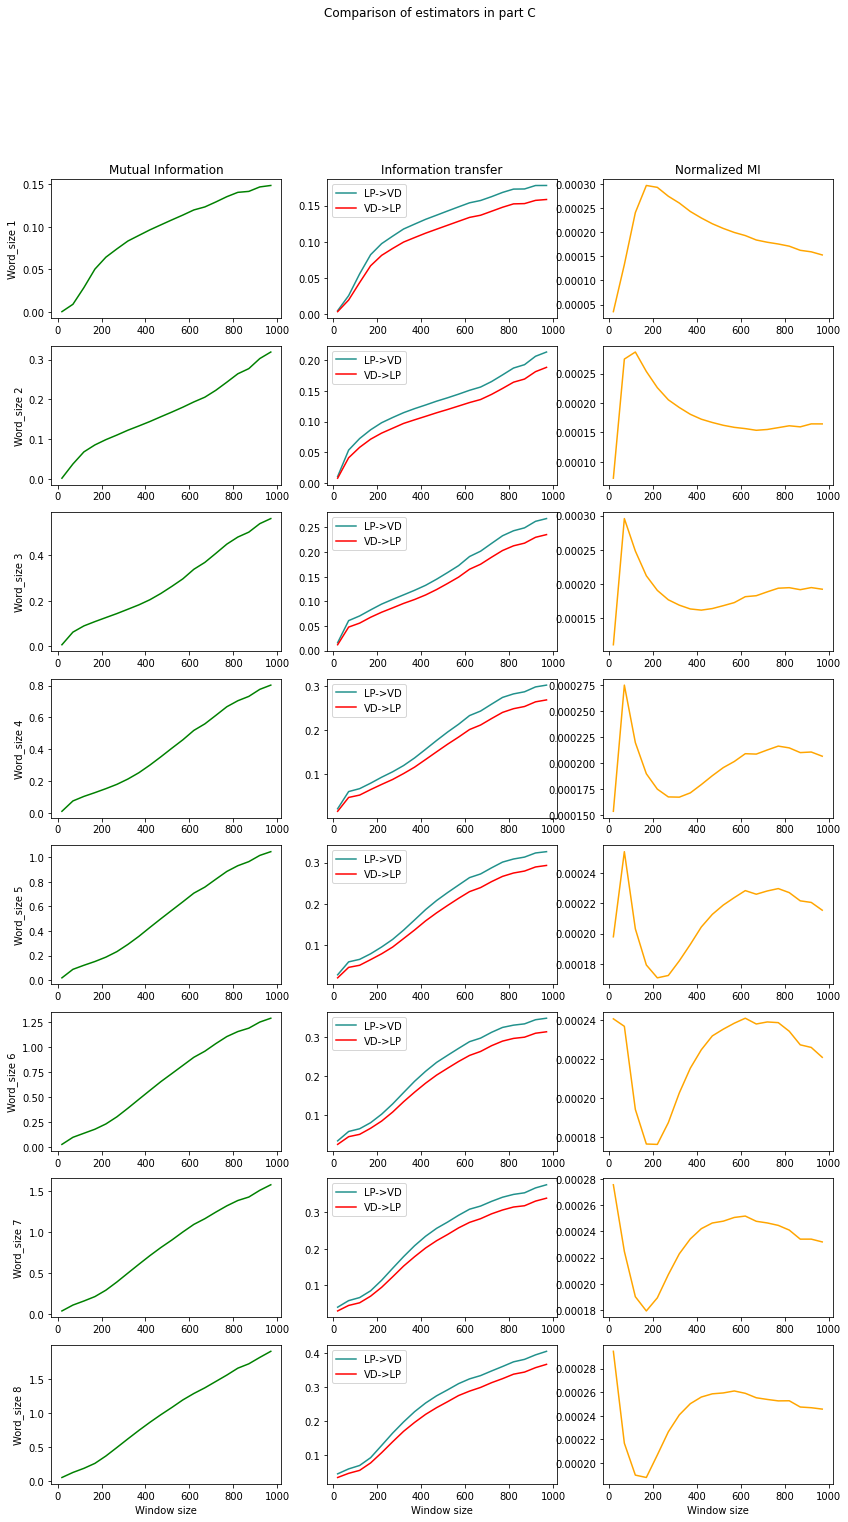

In [38]:
plot_mi_transfer_estimators(estimators_C,w_sizes,word_sizes,name = "Comparison of estimators in part C")

En este caso, el análisis es exactamente el mismo. La única diferencia que podemos apreciar para este trozo C es que el valor máximo de la información mutua que se obtiene es algo menor que en el caso anterior. Además, en el tamaño máximo de palabra, en el trozo C las transferencias de información entre las series son más parejas en el trozo anterior que en este, que conforme avanza el tamaño de ventana se distancian.

Por último, analizamos el trozo de recuperación:

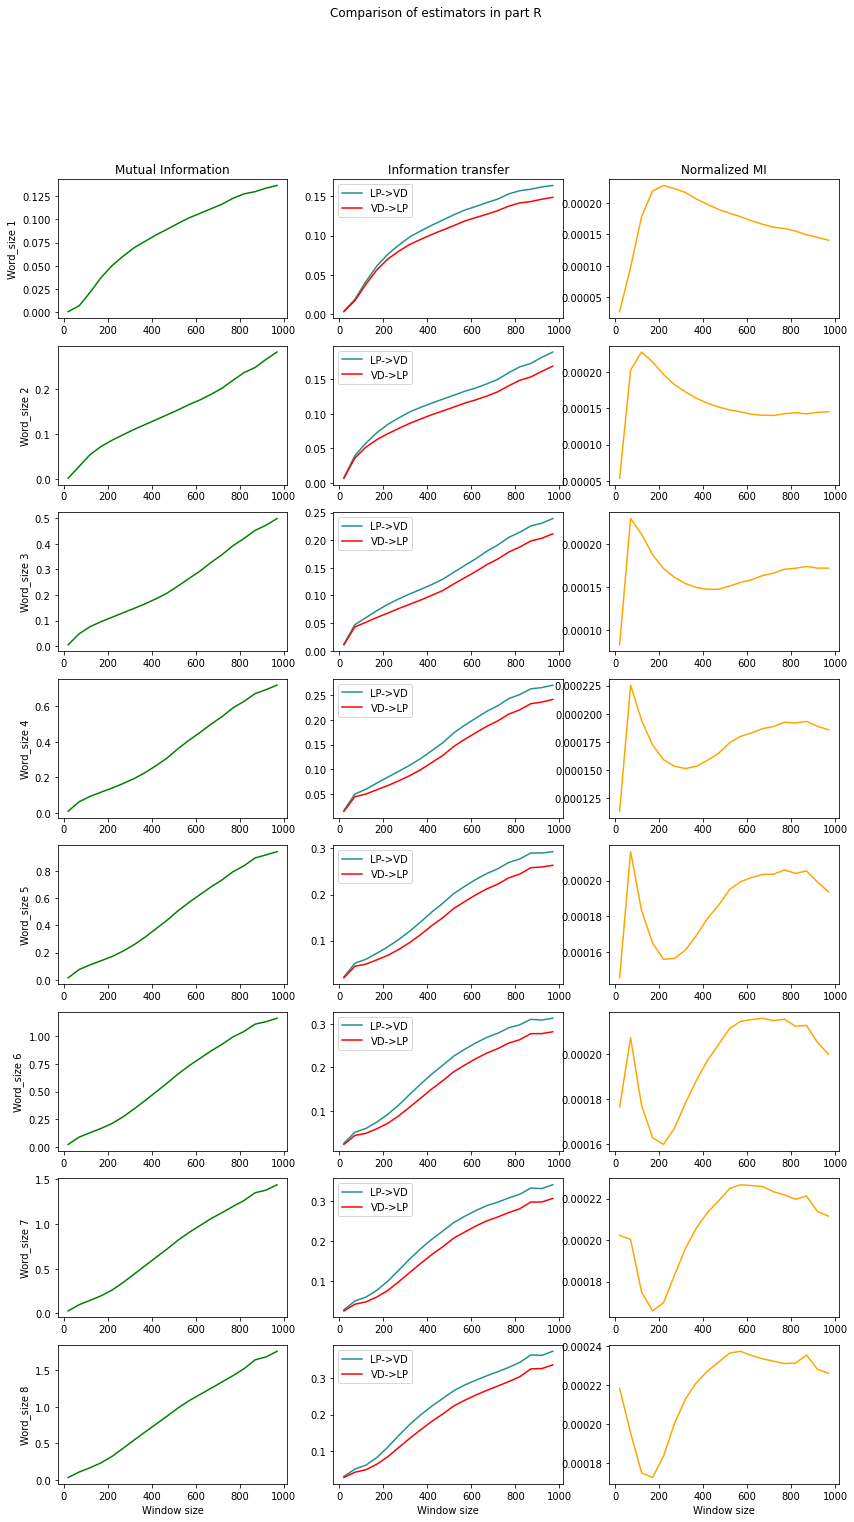

In [39]:
plot_mi_transfer_estimators(estimators_R,w_sizes,word_sizes,name = "Comparison of estimators in part R")

En este trozo, las gráficas vuelven a tener aproximadamente las mismas formas, aunque los valores para este último trozo parecen de nuevo menores que en los dos casos anteriores. Como comentábamos en el tamaño de ventana fijo, esto tiene sentido en el contexto de nuestro problema.

# 5. Cambio de codificación: SAX

Hasta ahora, hemos creado una representación de nuestros datos utilizando ciertas propiedades (en particular, la distancia entre spikes) que hemos encontrado en nuestros propios datos. Hemos visto que esta representación nos ha permitido mantener la información relevante que teníamos en nuestro conjunto inicial, utilizando únicamente poco más de un $1\%$ del espacio inicial, lo cual es muy eficiente para nuestro trabajo de obtener información entre señales. Vamos a introducir ahora otra forma diferente de crear representaciones, basado en el siguiente artículo: [A Symbolic Representation of Time Series, with Implications for
Streaming Algorithms](https://www.cs.ucr.edu/~eamonn/SAX.pdf).

La técnica usada se llama **SAX (Symbolyc Aggregate approXimation)**. Dado un vector de $\mathbb R^n$, reducirlo a un vector de $\mathbb R^w$ con $w << n$ tratando, igual que en otras técnicas de reducción de dimensionalidad, de mantener la información. Este algoritmo utiliza como base la salida que proporciona el algoritmo **PAA (Piecewise Aggregate Approximation)**, que explicaremos primeramente. Introducimos ciertos elementos de notación que usaremos en la explicación:

- $C$ será una serie temporal $C = c_1,\dots,c_n$.
- $\bar C$ será una serie temporal reducida $\bar C = \bar c_1,\dots, \bar C_w$ utilizando PAA.
- $\hat C$ será una representación simbólica de una serie temporal $\hat C = \hat c_1,\dots,\hat c_w$
- $w$ será el número de segmentos en los que el algoritmo PAA representará la serie.
- $a$ es el tamaño del alfabeto (los posibles valores que toma la serie temporal reducida).

El algoritmo SAX usará una representación intermedia entre la serie temporal y las cadenas simbólicas que se pretenden generar. Gracias a esto, obtenemos dos ventajas:

1. Reducción de dimensionalidad.
2. Conseguir una medida de la distancia entre dos cadenas de símbolos que es una cota inferior de la verdadera distancia entre las series temporales originales.

## PAA

Explicamos ahora el algoritmo PAA de reducción de dimensionalidad. Lo primero que se hace es realizar una estandarización para que esta tenga media $0$ y varianza $1$, pues sabemos que no tiene sentido comparar series temporales que tienen diferentes amplitudes.

Estamos en condiciones de continuar. Esencialmente, el algoritmo consiste en tomar como $i-$ésimo elemento de $\bar C = \bar c_1,\dots \bar c_w$ como:
$$
\bar c_i = \frac{w}{n} \sum_{j = \frac{n}{w}(i-1)+1}^{\frac{n}{w}i} c_j
$$

Aunque esta fórmula pueda parecer poco intuitiva, la explicación es razonablemente sencilla: consiste en reducir la serie de $n$ a $w$ dimensiones, donde el valor de cada dimensión de salida $w_i$ es la media de los valores que hay en una ventana que tiene el mismo tamaño que todas las demás que se han usado para dividir el espacio.


## Discretización

Teniendo nuestra representación PAA de la serie temporal original, nos gustaría tener una técnica de discretización que produzca los símbolos de forma equiprobable. Esto se consigue gracias a que las series temporales normalizadas siguen una distribución gaussiana. Sabienod esto, podemos determinar los **breakpoints** que producen áreas del mismo tamaño (digamos, tamaño $a$) bajo la curva Gaussiana. Formalmente, se definen los *breakpoints* como una lista ordenada $B = \beta_1,\dots,\beta_{a-1}$ tales que el área bajo la curva Gaussiana una distribución $N(0,1)$ desde $\beta_i$ hasta $\beta_{i+1}$ es igual a $\frac{1}{a}$. Podemos simplemente, por ejemplo, utilizar los cuantiles de esta distribución.

Seleccionado el número de particiones que queremos realizar y obtenidos los *breakpoints*, debemos convertir nuestra secuencia PAA en una secuencia de símbolos. Supongamos que hemos decidido dividir nuestro conjunto usando $k \in \mathbb N$ *breakpoints*. Obtenemos entonces nuestro conjunto de símbolos $\hat C = \hat c_1,\dots ,\hat c_w$ del siguiente modo: 
1. Consideramos $\alpha_1 = a$ y $\alpha_j$ la $j-$ésima letra del abecedario.
2. Teniendo el vector $\bar C$, lo convertimos a $\hat C$ transformando cada elemento de la forma:
$$
\hat c_i = \alpha_j \Leftrightarrow \beta_{j-1} \leq \hat c_i \beta_j
$$

Tendríamos entonces nuestra representación SAX en el vector $\hat C$. Como hemos comentado, podemos entonces definir una distancia (por ejemplo, generalizar la euclídea) para hacer una distancia entre representaciones de series temporales.


## Repercusión de SAX sobre la información mutua y transferencia de información

Uno de los resultados clave de este artículo es que la distancia entre las distintas representaciones es equivalente:



Considerando la distancia euclídea, punto a punto, entre las series temporales originales (A)
$$
D(Q, C) \equiv \sqrt{\sum_{i=1}^n (q_i - c_i)^2},
$$

la distancia euclídea tras las aplicación de PAA (B) 
$$
DR(\bar Q, \bar C) \equiv \sqrt \frac{n}{w} \sqrt{\sum_{i=1}^w (\bar q_i - \bar c_i)^2},
$$

y la distancia entre dos palabras tras las aplicación de SAX (C) 
$$
MINDIST(\hat Q, \hat C) \equiv \sqrt \frac{n}{w} \sqrt{\sum_{i=1}^w (dist(\hat q_i, \hat c_i))^2},
$$

se puede demostrar que estas tres distancias son equivalentes. **Esto es especialmente relevante para nuestro estudio sobre la información mutua y la transferencia de información**, ya que sin estos resultados teóricos sobre la relación entre las series transformadas y las series sin transformar, no podríamos estar seguro de si las variables de información obtenidas han sido influenciadas por las transformaciones aplicadas a las series.

## Implementación

Podemos implementar este algoritmo de creación de representaciones de series temporales. Los parámetros (o hiperparámetros, si quisiésemos optimizarlos) que debemos tener en cuenta son:
- $w$ el número de ventanas en el que queremos dividir la serie temporal inicial.
- $a$ el número de *breakpoints* o trozos con la misma área bajo la curva siendo la curva la Gaussiana de una $N(0,1)$. Es decir, el número de letras del alfabeto a utilizar en nuestra representación.

In [40]:
from scipy.stats import norm
from string import ascii_lowercase
from sklearn.preprocessing import StandardScaler
from math import ceil

def PAA(vec, window_size=70):
    return np.array([ np.mean(vec[i: i+window_size])
                for i in range(0, len(vec), window_size)])

def SAX_from_PAA(vec_paa, percentiles):
    return [ ascii_lowercase[np.sum( percentiles < x )] for x in vec_paa ] # norm.pdf(x)
    
def SAXify(df, n_windows=None, n_letters=3):
    cols_result = []
    
    window_size = 70 if n_windows is None else ceil(df.shape[0]/n_windows)

    # Obtain N(0,1) quantiles
    percentiles = [ norm.ppf(k/n_letters) for k in range(1, n_letters)]

    for col in range(len(df.columns)):
        vec = np.array(df.iloc[:,col]).reshape(-1,1)

        # Normalize the values
        vec_standarized = StandardScaler().fit_transform(vec)

        # Obtain the PAA representation
        vec_paa = PAA(vec_standarized, window_size)

        # Obtain SAX representation
        result = SAX_from_PAA(vec_paa, percentiles)

        #Update vector in df
        cols_result.append(result)
    
    return pd.DataFrame(np.array(cols_result).T, columns=df.columns)

def letter_to_numbers(df):
    result = []
    for col in range(len(df.columns)):
       result.append(df.iloc[:,col].map(ord) - 97)
    return pd.DataFrame(np.array(result).T, columns=df.columns)

Veamos el resultado de nuestro algoritmo en un pequeño ejemplo. Este se aplica por columnas, que tendrán cada una 10 elementos. Al tomar 5 ventanas reduciremos a la mitad el número de filas del resultado. Por otro lado, tomamos 3 letras del alfabeto `abc` para este ejemplo. Podemos apreciar que los resultados siguen, por columnas, la misma forma geométrica que hacen los datos iniciales.

In [41]:
df2 = pd.DataFrame(np.array([[0, 2], [2, 4], [4, 6], [6, 8], [8, 10], [8, 12], [6, 12], [4, 12], [2, 0], [0, 0]]),
                   columns=['c1', 'c2'])
print('Datos originales:\n {}'.format(df2))


df2_sax = SAXify(df2, n_windows = 5, n_letters = 3)
print('Datos tras aplicar SAX con 5 ventanas y 3 letras:\n {}'.format(df2_sax))

Datos originales:
    c1  c2
0   0   2
1   2   4
2   4   6
3   6   8
4   8  10
5   8  12
6   6  12
7   4  12
8   2   0
9   0   0
Datos tras aplicar SAX con 5 ventanas y 3 letras:
   c1 c2
0  a  a
1  b  b
2  c  c
3  b  c
4  a  a


Implementamos a continuación una función adicional que encapsula toda esta funcionalidad: dado un dataframe aplicará el algoritmo SAX por columnas y devolverá el estimador desarrollado al principio de esta práctica. Pintamos los resultados para el trozoC.

In [42]:
def get_SAX_estimator(df, n_windows=None, n_letters=3, word_sizes=np.arange(1,9,1)):
    trozoC_SAX = SAXify(df, n_windows=n_windows, n_letters=n_letters)
    trozoC_SAX_numbers = letter_to_numbers(trozoC_SAX)
    
    X, Y = get_LP_VD(trozoC_SAX_numbers)
    return MI(X, Y, word_sizes)

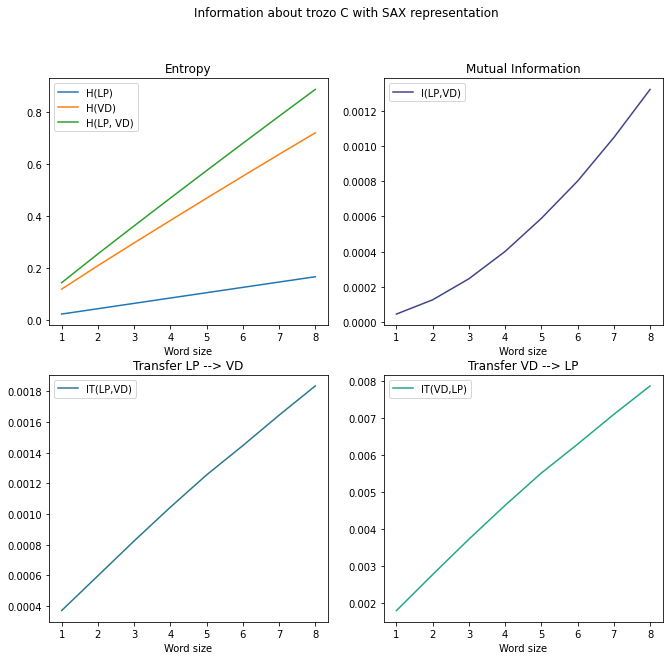

In [43]:
estimator_C = get_SAX_estimator(trozoC)
plot_entropies_mi_transfer(estimator_C, name = "Information about trozo C with SAX representation")

Podemos apreciar como en general todos los valores son menores que los encontrados en previas iteraciones de este estimador. Tras analizar los datos y el algoritmo llegamos a la conclusión de que, dado que cada vez que hay un spike en una de nuestras series temporales también hay una previa y posterior caída de la misma, realizar la media de estos valores está neutralizando toda la información de los spikes. Para comprobar nuestra hipótesis, aplicamos el valor absoluto a nuestros datos y volvemos a realizar el mismo análisis utilizando la representación SAX y nuestra clase estimador.

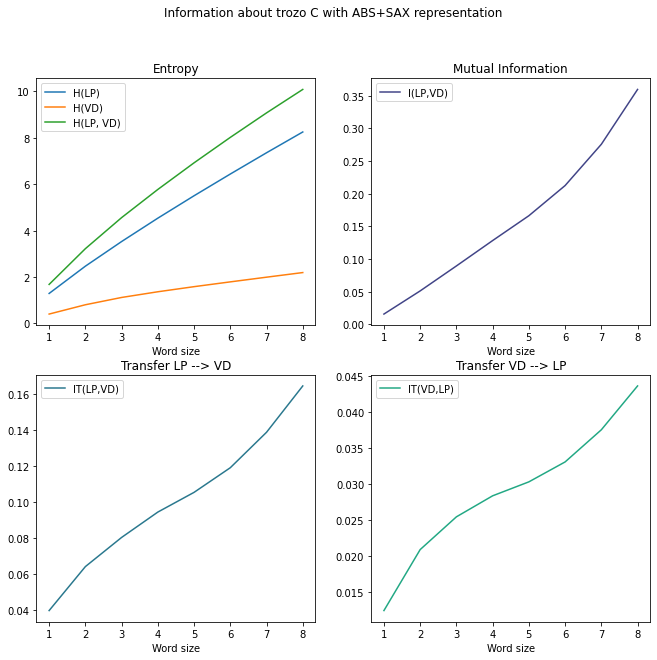

In [44]:
def abs_df(df):
    result = []
    for col in range(len(df.columns)):
       result.append(abs(df.iloc[:,col]))
    return pd.DataFrame(np.array(result).T, columns=df.columns)


trozoC_abs = abs_df(trozoC)
estimator_C_abs = get_SAX_estimator(trozoC_abs)
plot_entropies_mi_transfer(estimator_C_abs, name = "Information about trozo C with ABS+SAX representation")

Podemos ver cómo las entropías, entropía conjunta, información mutua y transferencia de información son muchísimo mayores en estos datos, **nuestra hipótesis era correcta**. Pasamos a analizar el resto de trozos utilizando esta nueva representación como hicimos con anterioridad.

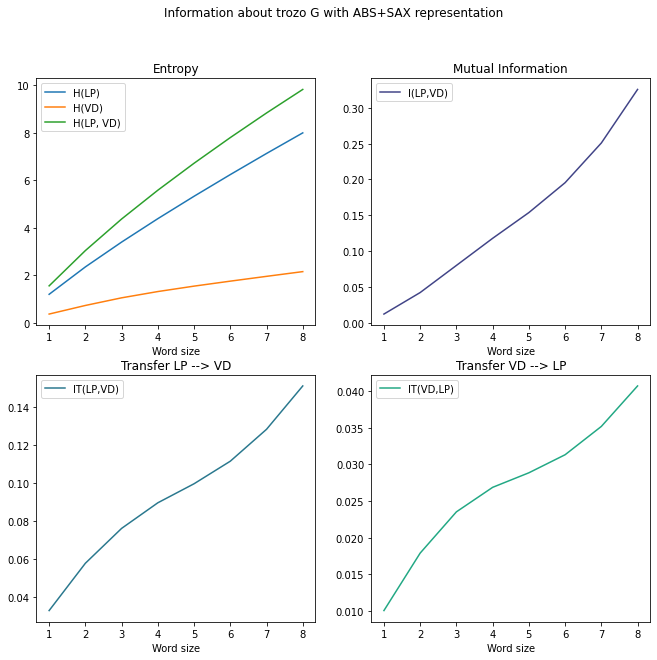

In [45]:
trozoG_abs = abs_df(trozoG)
estimator_G_abs = get_SAX_estimator(trozoG_abs)
plot_entropies_mi_transfer(estimator_G_abs, name = "Information about trozo G with ABS+SAX representation")

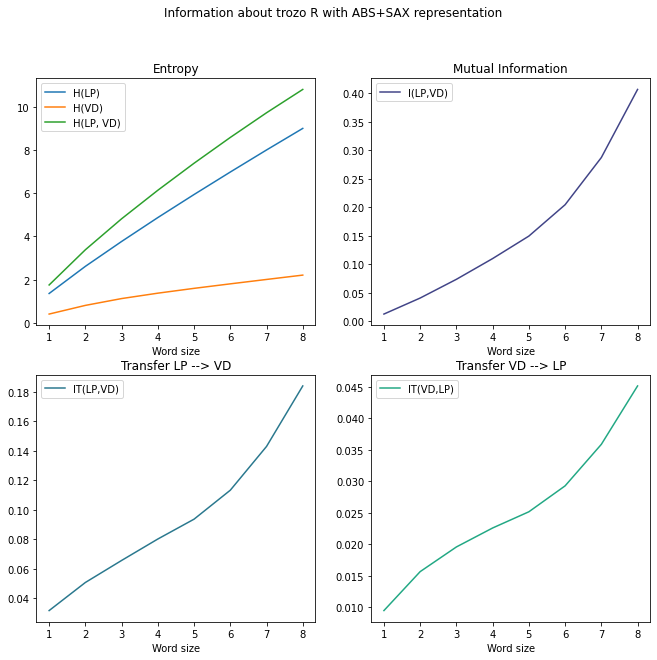

In [46]:
trozoR_abs = abs_df(trozoR)
estimator_R_abs = get_SAX_estimator(trozoR_abs)
plot_entropies_mi_transfer(estimator_R_abs, name = "Information about trozo R with ABS+SAX representation")

Podemos apreciar cómo los distintos valores representados apenas varían de un trozo a otro, los valores máximos y mínimos son parecidos entre las distintas series temporales, así como las formas de las gráficas. Si que puede apreciarse cierto cambio en la forma -además del númerico previamente comentado- cuando comparamos con los resultados previos a la aplicación del valor absoluto: la transferencia de información era completamente lineal y pasa a asemejarse a un polinomio cúbico.

Por otro lado, si comparamos estos valores con las gráficas semejantes obtenidas a partir de nuestra representación vemos cambios significativos en la comparación de las entropías: Anteriormente la entropía conjunta era notablemente superior a las entropías independientes y ahora la entropía de la serie LP se aproxima considerablemente a la conjunta. Lás únicas diferencias que hemos podido apreciar en los datos entre las series LP y VD por separado ha sido el número de spikes y la distribución de los mismos, por lo que la única hipótesis posible es que la nueva representación utilizando SAX transforma dichas variaciones en un aumento de la entropía.

Por último, cabe destacar que en esta representación no apreciamos una disminución en la información mutua entre las series LP y VD de los trozos C y G al de recuperación como pudimos observar en nuestra representación.

## 5.1 Estudio de hiperparámetros: número de ventanas

Procedemos a realizar una serie de experimentos sobre los hiperparámetros del algoritmo SAX para comprobar como afecta a las representaciones obtenidas. Estos parámetros son:

- El número de ventanas: `w`.
- El número de letras (cortes) utilizados: `a`.

En primer lugar transformaremos el parámetro `w` en ***tamaño de ventana*** para que los resultados obtenidos sean comparables con los obtenidos con nuestra representación. Realizamos una comparativa teniendo en cuento distintos tamaños de palabra y tamaños de ventana.

In [47]:
def SAX_windows_experiment(df, window_sizes, word_sizes, n_letters=3,save= True, name_save_object = ""):
    # The discretized data is common since it does not use window size, just discretizes peaks
    if exists(name_save_object):
        print("Estimators already computed!")
        return load_object(name_save_object)
    estimators = []
    for w_size in tqdm(window_sizes):
        abs_part = abs_df(df)
        est  = get_SAX_estimator(abs_part,
                                 n_windows= ceil(df.shape[0]/w_size),
                                 n_letters=n_letters,
                                 word_sizes=word_sizes)
        estimators.append(est)
    
    if name_save_object != "" and save:
        save_object(estimators, name_save_object)
    return estimators

In [48]:
window_sizes = np.arange(20,1011,50) 
word_sizes = np.arange(1,9,1)

estimators_SAX_C = SAX_windows_experiment(trozoC, window_sizes, word_sizes,save= True,name_save_object = "estimator_SAX_C")

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:29<00:00, 10.47s/it]


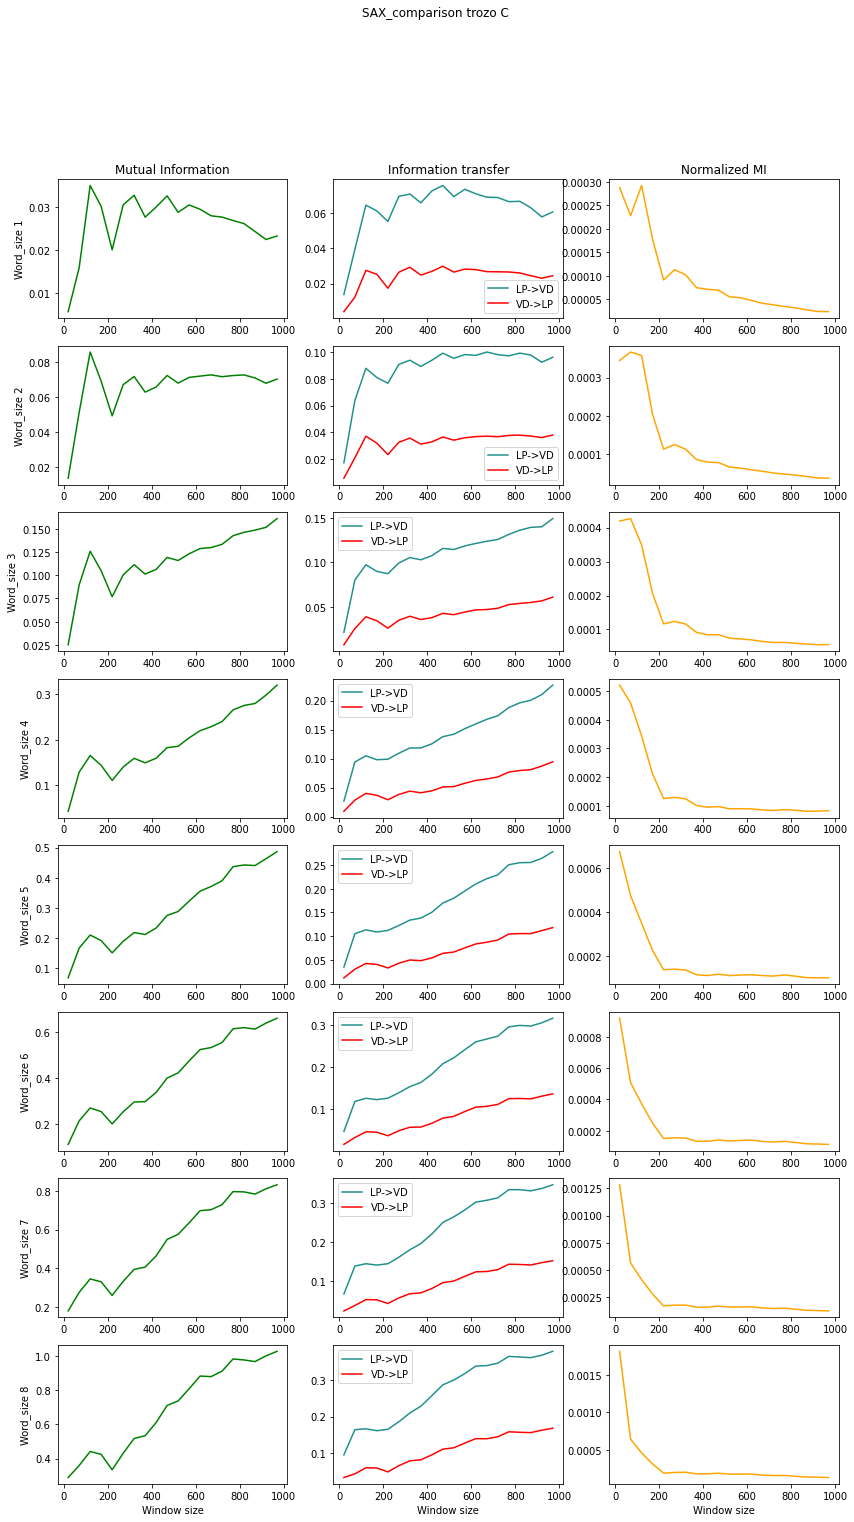

In [49]:
plot_mi_transfer_estimators(estimators_SAX_C, window_sizes=window_sizes, word_sizes=word_sizes, name="SAX_comparison trozo C")

In [50]:
estimators_SAX_G = SAX_windows_experiment(trozoG, window_sizes, word_sizes,save= True,name_save_object = "estimator_SAX_G")

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:19<00:00,  9.98s/it]


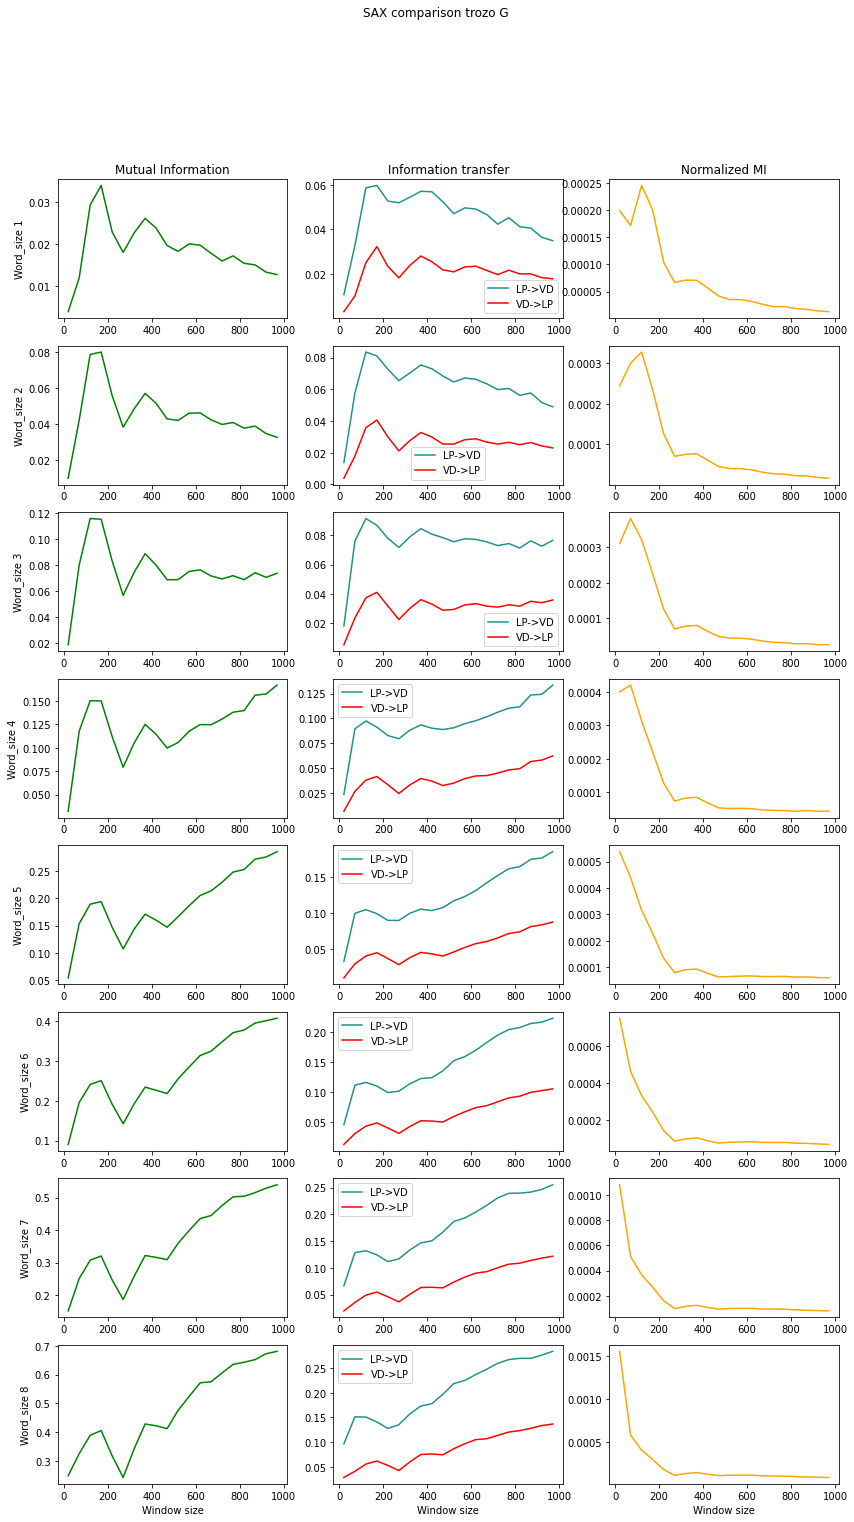

In [51]:
plot_mi_transfer_estimators(estimators_SAX_G, window_sizes=window_sizes, word_sizes=word_sizes, name="SAX comparison trozo G")

In [52]:
estimators_SAX_R = SAX_windows_experiment(trozoR, window_sizes, word_sizes,save= True,name_save_object = "estimator_SAX_R")

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:48<00:00,  8.42s/it]


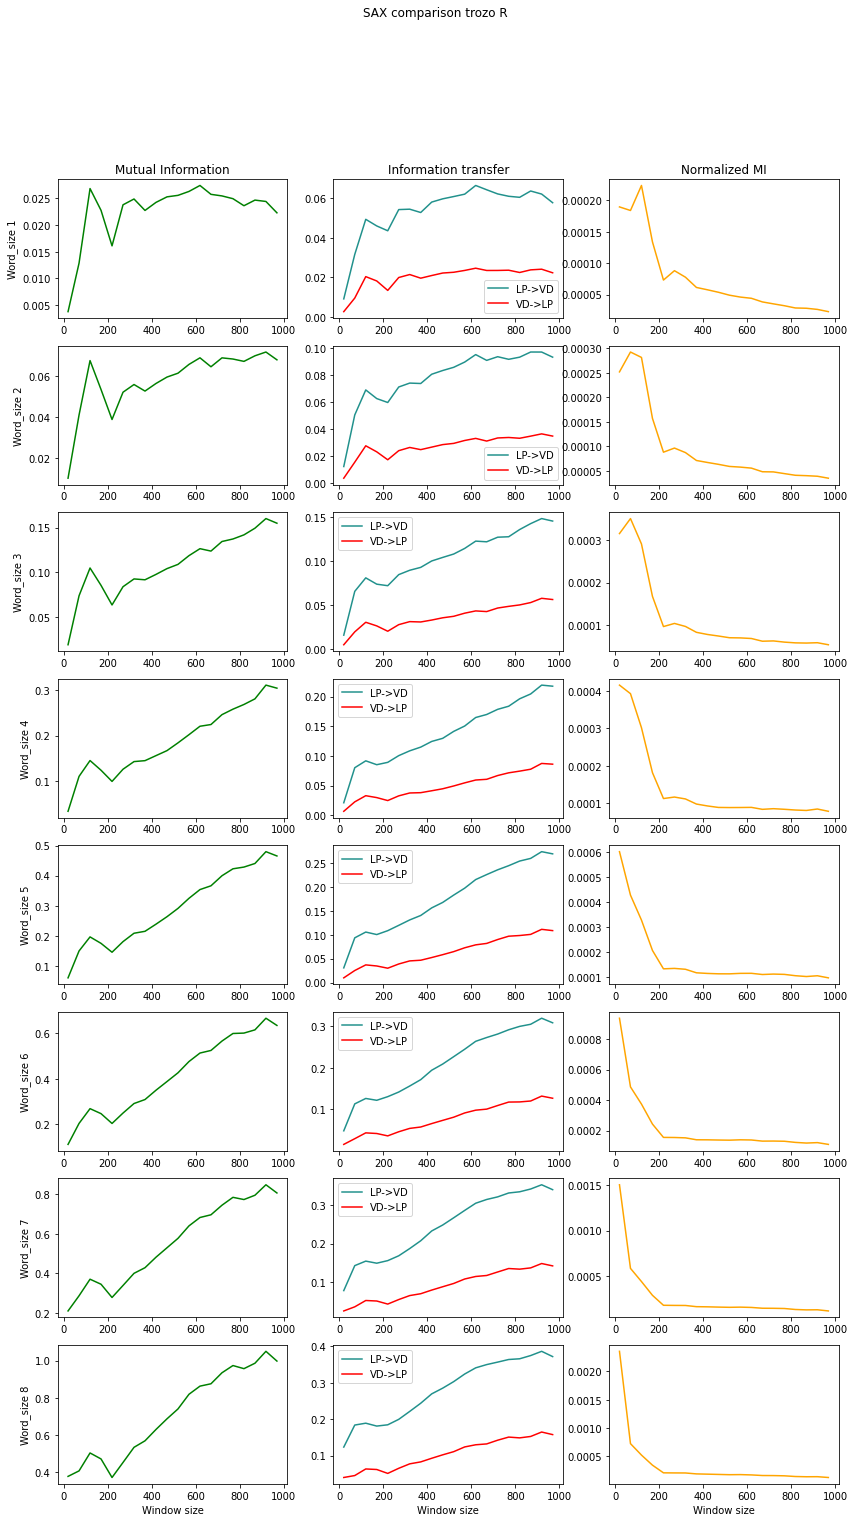

In [53]:
plot_mi_transfer_estimators(estimators_SAX_R, window_sizes=window_sizes, word_sizes=word_sizes, name="SAX comparison trozo R")

Lo primero que llama la atención es la absoluta reducción en la información mutua normalizada que hemos obtenido en todas las ejecuciones. Aunque obtenemos valores numéricos parecidos, sobretodo para tamaños de ventanas reducidos, la diferencia se hace más que notable cuando aumentamos el tamaño de ventana. A pesar de los resultados sobre la información mutua normalizada, la no normalizada se comporta de manera similar, creciendo conforme lo hace el tamaño de ventana. Sin embargo, sabemos que este crecimiento puede deberse más a cómo afecta el tamaño de ventana a la información mutua que a un aumento real en la misma, como bien revela la normalizada. Así mismo, vemos como el incremento en la información mutua en la representación original era completamente lineal y aquí tiene un mínimo local sobre tamaño de ventana 200.

Por otro lado, la transferencia de inferencia de información en las representaciones originales crecía de forma equivalente, como ocurre en la representación de SAX, y sin embargo hay una diferencia notable entre la transferencia `LP->VD` y la transferencia `VD->LP` que no eran tan apreciable anteriormente.

La conclusión final de este experimento es que no por aumentar el tamaño de ventana obtenemos mejores resultados en la información mutua o la transferencia de información. De hecho, ocurre justo lo contrario. Estos resultados son muy naturales: conforme aumentamos el tamaño de ventana de forma arbitraria la media se realiza sobre ventanas más grandes. Incluso si uno o varios spikes ocurren en la misma ventana, el valor medio caerá. Por lo tanto los spikes, nuestros eventos realmente importantes y donde reside la transferencia de información entre estas series temporales, quedan oscurecidos frente al resto de valores.

## 5.2 Estudio de hiperparámetros: tamaño de alfabeto

En segundo lugar, procedemos a estudiar el hiperparámetro `a`, que representa el número de letras del alfabeto. Para ello representamos una serie de gráficas equivalentes a las del caso anterior, donde sustituimos el tamaño de ventana `w` por el susodicho parámetro `a`. 

In [54]:
def SAX_windows_experiment_letters(df, window_size = 1000, word_sizes = np.arange(1,9,1) , n_letters=3,offset = 3,save= True, name_save_object = ""):
    # The discretized data is common since it does not use window size, just discretizes peaks
    if exists(name_save_object):
        print("Estimators already computed!")
        return load_object(name_save_object)
    estimators = []
    for letters in tqdm(range(offset, n_letters)):
        abs_part = abs_df(df)
        est  = get_SAX_estimator(abs_part,
                                 n_windows= ceil(df.shape[0]/window_size),
                                 # Sum 2 because the minimum is 2
                                 n_letters=letters+2,
                                 word_sizes=word_sizes)
        estimators.append(est)
    
    if name_save_object != "" and save:
        save_object(estimators, name_save_object)
    return estimators
    

In [55]:

word_sizes = np.arange(1,9,1)
n_letters = 25
offset = 3
computed_letters = n_letters - offset

estimators_SAX_C_letters = SAX_windows_experiment_letters(trozoC, n_letters = n_letters,save= True,name_save_object = "estimator_SAX_C_letters")
estimators_SAX_G_letters = SAX_windows_experiment_letters(trozoG, n_letters = n_letters,save= True,name_save_object = "estimator_SAX_G_letters")
estimators_SAX_R_letters = SAX_windows_experiment_letters(trozoR, n_letters = n_letters,save= True,name_save_object = "estimator_SAX_R_letters")

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:44<00:00,  2.04s/it]


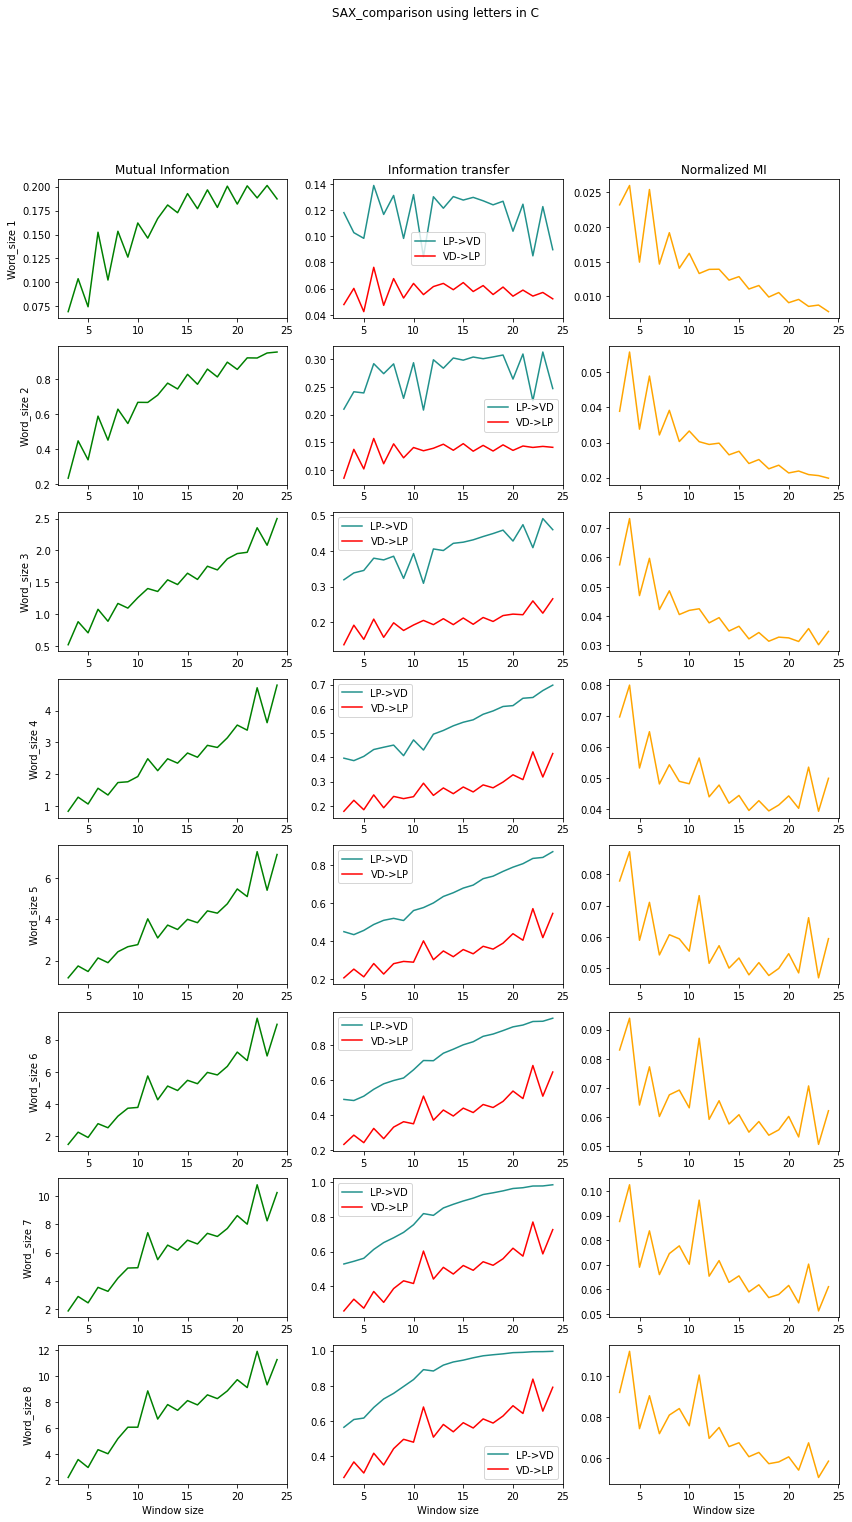

In [56]:
plot_mi_transfer_estimators(estimators_SAX_C_letters, window_sizes=np.arange(offset,n_letters,1), word_sizes=word_sizes, name="SAX_comparison using letters in C")

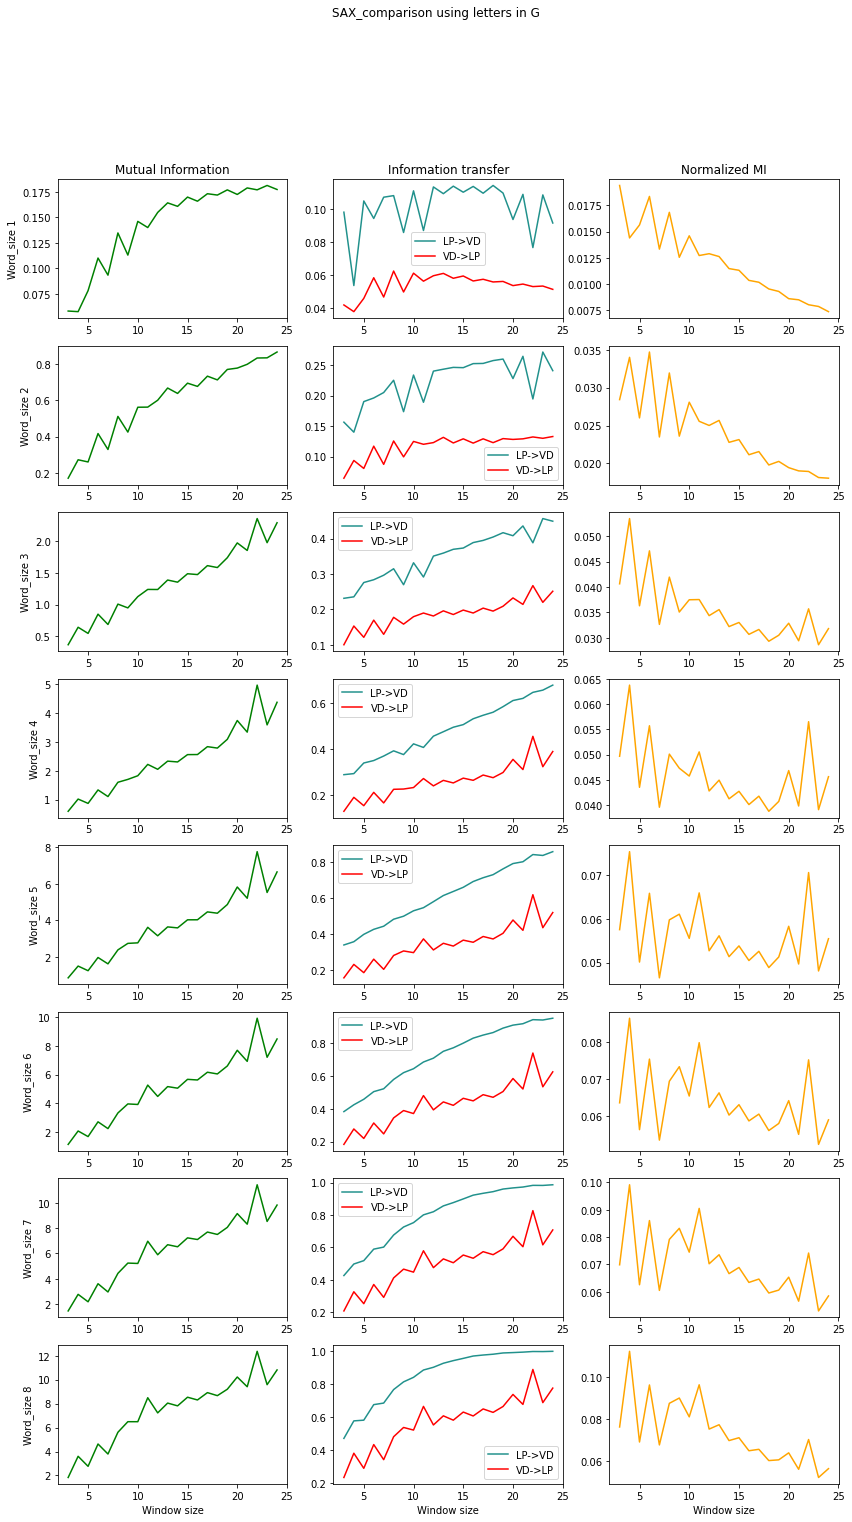

In [57]:
plot_mi_transfer_estimators(estimators_SAX_G_letters, window_sizes=np.arange(offset,n_letters,1), word_sizes=word_sizes, name="SAX_comparison using letters in G")

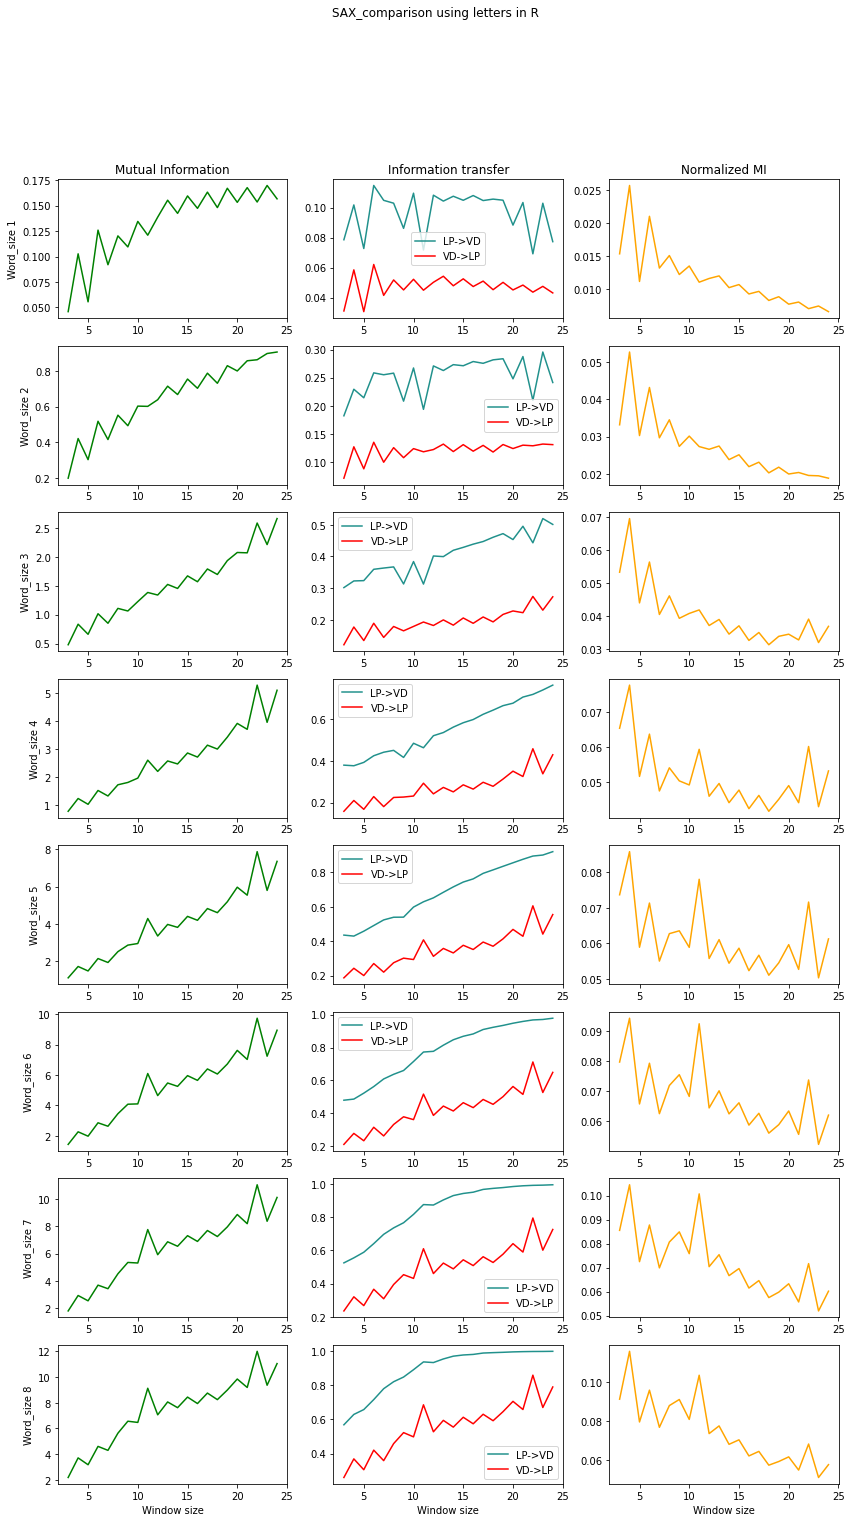

In [58]:
plot_mi_transfer_estimators(estimators_SAX_R_letters, window_sizes=np.arange(offset,n_letters,1), word_sizes=word_sizes, name="SAX_comparison using letters in R")

En estas comparativas volvemos a no apreciar diferencias significativas en el comportamiento de la información mutua y transferencia de información entre las distintas series temporales, salvo en la información mutua normalizada donde los trozos C y G obtienen valores superiores a los del trozo C.

Por otro lado, centrando nuestra atención en el objetivo principal de los cálculos realizados, apreciamos un descenso en la información mutua normalizada conforme aumenta indiscriminadamente el tamaño de alfabeto. Los mayores valores se obtienen en puntos distintos según el tamaño de palabra, oscilando entre tamaño de alfabeto cercano a 5 hasta 13. En particular, el máximo valor parece converger a 13 cuando aumenta lo suficiente el tamaño de palabra.

Por otro lado, la información mútua no normalizada y las transferencias de información crecen de formas equivalentes a las vistas hasta ahora. Son especialmente relevantes en este caso los pequeños mínimos y máximos locales que se suceden en todos los valores representados. Nuestra hipótesis inicial justificaba este comportamiento diferenciando valores pares e impares para los tamaños de alfabeto. En el caso de valores impares, uno de los cortes queda completamente centrado en la media de la distribución `N(0,1)` utilizada. Esta letra intermedia asociaría de forma certera los valores intermedios que pueden considerarse prácticamente nulos.

Sin embargo, una visualización concienzuda de los valores revela un cambio en la rotación mínimos ç/máximos alrededor de tamaño de alfabeto 13. Esto podría revelar que o bien nuestra hipótesis inicial es errónea, o bien que al aumentar lo suficiente el tamaño de alfabeto se obtienen mejores resultados para valores pares de alfabeto por alguna razón desconocida.

En resumen, este experimento revela que mayores tamaños de alfabeto no aumentan la información mutua normalizada de forma indiscriminada. Análisis en profundidad y en comparativa con distintas tamaños de ventanas han de ser realizados para optimizar el valor de este hiperparámetro en detalle.

## 5.3. Comparativa de representaciones

En último lugar, realizamos una comparativa del rendimiento de nuestra representación inicial con conocimiento del problema y los datos frente a la representación SAX realizada, a partir de los valores de información mutua e información mutua normalizada. Mostraremos el patrón de gráficas al que estamos ya acostumbrados, mostrando en primer lugar la información mutua sin normalizar para distintos tamaños de ventana y tamaño de palabra en los distintos trozos. En segundo lugar, mostramos la información mutua normalizada con el mismo esquema de hiperparámetros.

In [59]:
def plot_comparison(estimators_ours, estimators_SAX,window_sizes, word_sizes ,normalized = False ,name = "Mutual Information Comparison our representation VS SAX"):
    fig, axs = plt.subplots(len(word_sizes), 3, figsize = (14, 24))
    fig.suptitle(name)

    colors = plt.cm.get_cmap(None,8)
    
    
    axs[0, 0].set_title("TrozoC")
    axs[len(word_sizes)-1, 0].set_xlabel("Window size")
        
    axs[0, 1].set_title("TrozoG")
    axs[len(word_sizes)-1, 1].set_xlabel("Window size")
        
        
    axs[0, 2].set_title("TrozoR")
    axs[len(word_sizes)-1, 2].set_xlabel("Window size")



    for i in range(len(word_sizes)):
        axs[i,0].set_ylabel("Word_size " + str(i+1))
        
        for j in range(3):
            
            if not normalized:
        
                axs[i, j].plot(window_sizes, [est.mutual_information_[i] for est in estimators_ours[j]],color = colors(1),label="Ours")
                axs[i, j].plot(window_sizes, [est.mutual_information_[i] for est in estimators_SAX[j]],color ='orange',label="SAX")
        
                
        
            else:
                axs[i,j].plot(window_sizes,[est.normalized_mi(window_sizes[k])[i] for k,est in enumerate(estimators_ours[j])],color=colors(1),label="Ours")
                axs[i,j].plot(window_sizes,[est.normalized_mi(window_sizes[k])[i] for k,est in enumerate(estimators_SAX[j])],color="orange",label="SAX")
    

            axs[i, j].legend()
        

    plt.show()

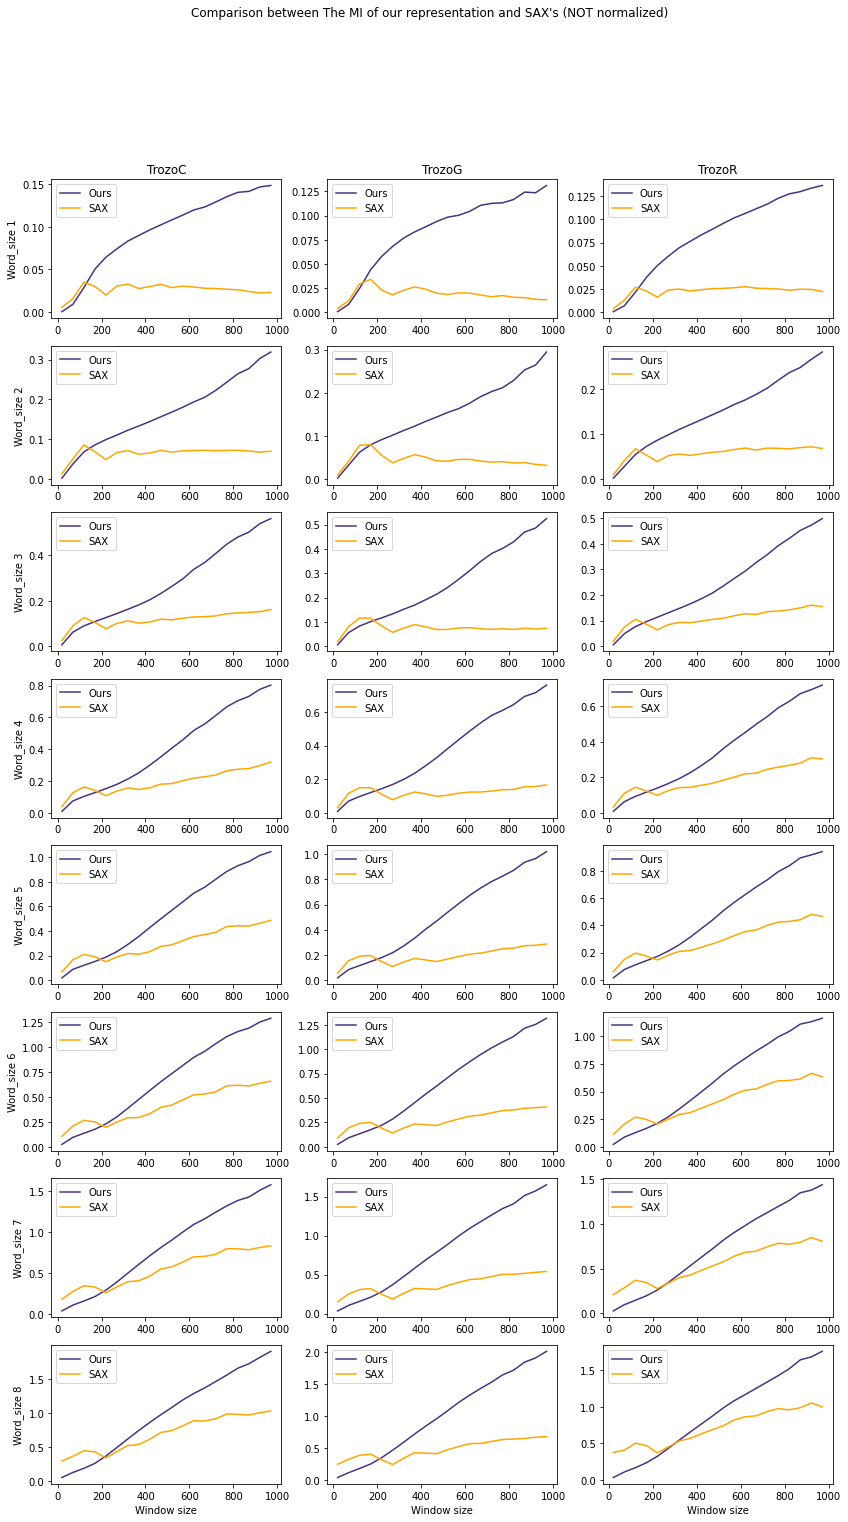

In [60]:
estimators_ours = [estimators_C,estimators_G,estimators_R]
estimators_SAX = [estimators_SAX_C,estimators_SAX_G,estimators_SAX_R]

window_sizes = np.arange(20,1011,50) 
word_sizes = np.arange(1,9,1)

plot_comparison(estimators_ours,estimators_SAX,window_sizes,word_sizes,normalized=False, name="Comparison between The MI of our representation and SAX's (NOT normalized)")

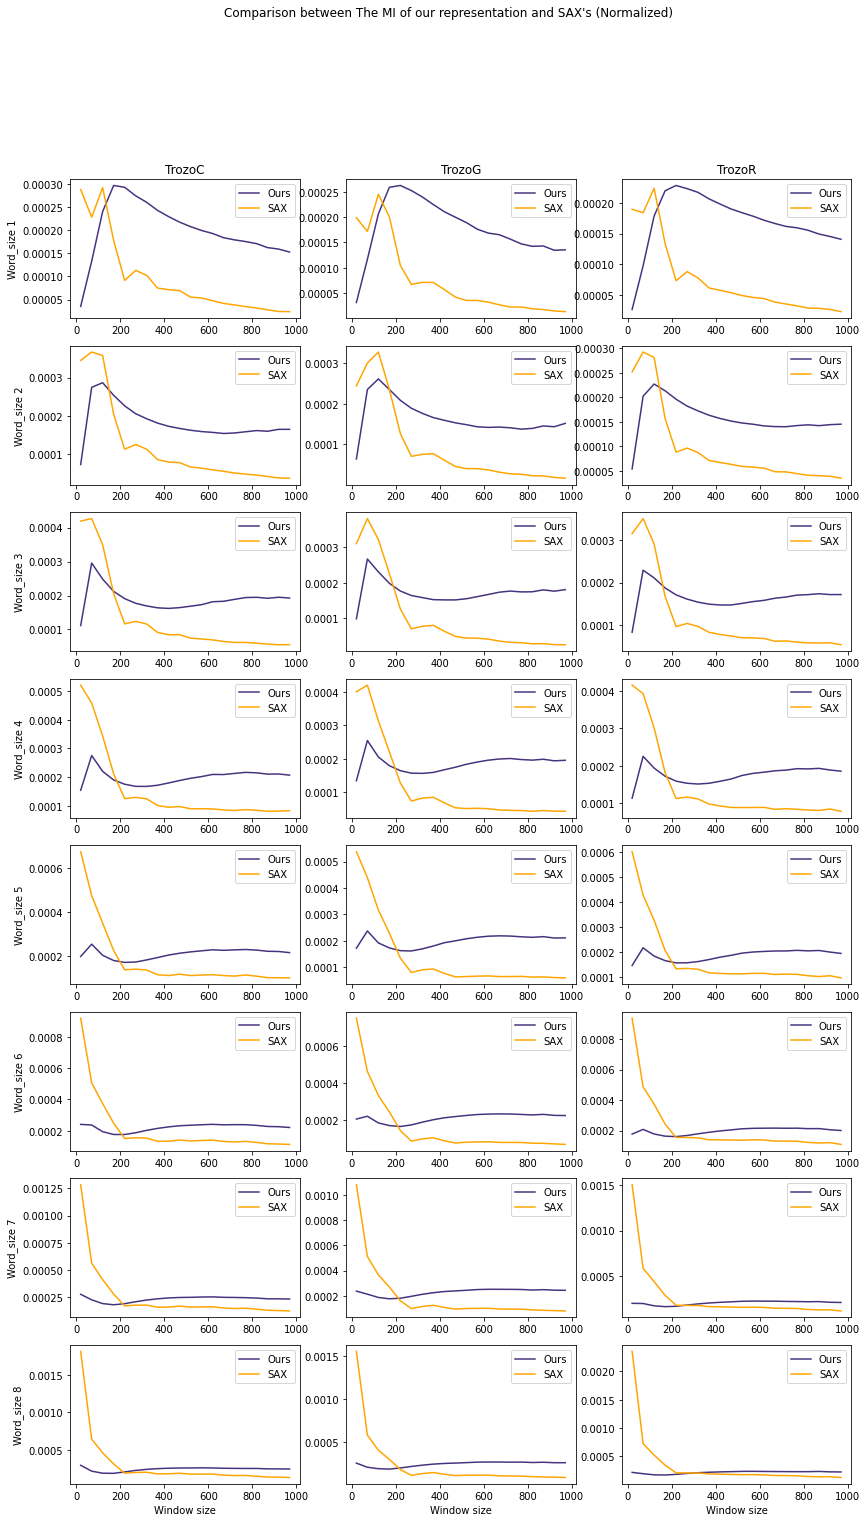

In [61]:
plot_comparison(estimators_ours,estimators_SAX,window_sizes,word_sizes,normalized=True, name="Comparison between The MI of our representation and SAX's (Normalized)")

En primer lugar podemos apreciar como no hay variaciones significativas entre la información mutua e información mutua normalizada para las distintas series temporales estudiadas además de las previamente comentadas. Observamos como la información mutua sin normalizar de nuestra representación crece linealmente con el tamaño de palabra en prácticamente todos los casos estudiados, mientras que la representación SAX obtiene un máximo local cercano a tamaño de ventana 100, y crece de forma lineal con mucha menos pendiente a partir de 200.

# 6. Conclusiones

En este trabajo, nos hemos enfrentado a un problema real. Hemos tomado una serie de decisiones de manera justificada y siguiendo un proceso lógico en los distintos aspectos a estudiar . Expresamos a continuación las conclusiones más relevantes, tanto en el aspecto de este trabajo como de nuestra propia comprensión de la teoría de información como de los problemas reales: 
 
1. Nos hemos reafirmado en la importancia de crear representaciones de los datos (en este caso, en el ámbito de las series temporales en el que poseen extrema relevancia sus *spikes* y la distancia entre los mismos). Hemos creado una representación que discretiza directamente la serie temporal inicial a una serie de ceros y unos usando un  alto percentil, pues determinamos que los spikes eran eventos muy raros y que tenían valores muy por encima de cualquier otro valor de la serie. **Conseguimos con esta representación mantener todos los spikes de nuestra serie temporal**, a la vez que **redujimos el tamaño un `98.5\%` respecto al tamaño inicial**, por lo que podemos afirmar que la representación creada es realmente satisfactoria.

2. Hemos estudiado cómo interactúan las series temporales que corresponden a dos tipos de neuronas (LP, VD) en estados de control, durante la inyección de GABA y por último en recuperación. **Hemos visualizado como claramente la transmisión de información de la neurona `LP` a la `VD` es mayor en el sentido opuesto**. Además, mediante el estudio de la información mutua de las representaciones de estas neuronas hemos comprobado una relación positiva entre los eventos (spikes) de dichas series temporales. La simetría de la información mutua nos indica que esta relación es bilateral.

3. **Hemos apreciado cambios significativos tanto en la información mutua como en la transmisión de información entre los trozos C, G y R**; obteniendo valores practicamente idénticos en los dos primeros y notables variaciones en durante la recuperación del cangrejo. 

4. Hemos estudiado, implementado y comparado una forma alternativa de obtener representaciones denominada **SAX**. Mediante este proceso, la reducción del tamaño es *fija*, siendo uno de los hiperparámetros a optimizar. Utilizando esta nueva representación **hemos demostrando que las relaciones ya encontradas entre las las series temporales es independiente a la represntación utilizada**, pues hemos obtenido resultados equivalentes con ambos métodos.

5. Hemos podido finalmente comparar las dos representaciones obtenidas, viendo que las dos obtienen resultados similares cuando hablamos de información mutua relativa, aunque si nos fijamos en las gráficas en las que dividimos por tamaño de palabra, la representación SAX de nuestras series temporales iniciales parece ser más inestable a la variación del cambio de tamaño de ventana, pues se observan numerosos picos en los gráficos. Esto también podría deberse a la decisión que hemos tomado de aplicar la función `f(x) = |x|` a todo nuestro conjunto de datos, **pues confirmamos la hipótesis sobre como las oscilaciones cercanas un spike mermaban los resultados del algoritmo SAX**.

6. En cuanto a los hiperparámetros de ambas de las representaciones, hemos de destacar un hecho sobre el resto de resultados obtenidos: **la información mutua siempre crece al aumentar el tamaño de ventana**. Sabemos que al tomar tamaños de ventana más grandes, podemos perder información al condensar varios spikes en una misma ventana, pero esto no parece ser relevante para la información mutua pues, como comentamos, siempre crece al aumentar el valor de este hiperparámetro.